<center><font size=6> Bank Churn Prediction </font></center>

Project #4: Introduction to Artificial Neural Networks<br>
Feb 2025<br>
presented by: Rolando Lopez (arlopeznieto@gmail.com)

## 0. PROBLEM STATEMENT

### 0.1. Context

Businesses like banks which provide service have to worry about problem of 'Customer Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on improvement of service, keeping in mind these priorities.

### 0.2. Objective

You as a Data scientist with the  bank need to  build a neural network based classifier that can determine whether a customer will leave the bank  or not in the next 6 months.

### 0.3. Data Dictionary

* CustomerId: Unique ID which is assigned to each customer

* Surname: Last name of the customer

* CreditScore: It defines the credit history of the customer.
  
* Geography: A customer’s location
   
* Gender: It defines the Gender of the customer
   
* Age: Age of the customer
    
* Tenure: Number of years for which the customer has been with the bank

* NumOfProducts: refers to the number of products that a customer has purchased through the bank.

* Balance: Account balance

* HasCrCard: It is a categorical variable which decides whether the customer has credit card or not.

* EstimatedSalary: Estimated salary

* isActiveMember: Is is a categorical variable which decides whether the customer is active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions etc )

* Exited : whether or not the customer left the bank within six month. It can take two values
** 0=No ( Customer did not leave the bank )
** 1=Yes ( Customer left the bank )

**Problem definition**

The problem at hand is to predict customer churn for a bank, i.e., whether a customer will leave the bank within the next six months. Churn is a critical issue for financial institutions, as losing customers can impact revenue and profitability. By analyzing various customer features, the goal is to build an artificial neural network that can identify customers at-risk, so that the bank can take proactive measures to improve customer retention and service quality.
<br>
<br>
Note: We will assume that 'Balance', 'isActiveMember', 'NumOfProducts' are features that represent historical and not post-churn data, as to avoid data-leakage thru features not available at the time of prediction.

## 1. ENV PREP (libraries, dataset and global variables)

### 1.1. Importing necessary libraries

In [ ]:
# # Installing the libraries with the specified version.
# !pip install tensorflow==2.15.0 scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.25.2 pandas==2.0.3 imbalanced-learn==0.10.1 -q --user

In [ ]:
# Installing the libraries with the latest versions.
!pip install tensorflow scikit-learn seaborn matplotlib numpy pandas imbalanced-learn -q --user

In [ ]:
!pip list | grep tensorflow
!pip list | grep scikit-learn
!pip list | grep seaborn
!pip list | grep matplotlib
!pip list | grep numpy
!pip list | grep pandas
!pip list | grep imbalanced-learn

tensorflow                         2.18.0
tensorflow-datasets                4.9.7
tensorflow-hub                     0.16.1
tensorflow-io-gcs-filesystem       0.37.1
tensorflow-metadata                1.16.1
tensorflow-probability             0.25.0
tensorflow-text                    2.18.1
scikit-learn                       1.6.1
seaborn                            0.13.2
matplotlib                         3.10.0
matplotlib-inline                  0.1.7
matplotlib-venn                    1.1.2
numpy                              1.26.4
geopandas                          1.0.1
pandas                             2.2.2
pandas-datareader                  0.10.0
pandas-gbq                         0.28.0
pandas-stubs                       2.2.2.240909
sklearn-pandas                     2.2.0
imbalanced-learn                   0.13.0


In [ ]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Library to split data
from sklearn.model_selection import train_test_split

# library to import to standardize the data
from sklearn.preprocessing import StandardScaler, LabelEncoder

# importing different functions to build models
import tensorflow as tf
from tensorflow import keras
from keras import backend
from keras.models import Sequential
from keras.layers import Dense, Dropout

# importing SMOTE
from imblearn.over_sampling import SMOTE

# importing metrics
from sklearn.metrics import confusion_matrix,roc_curve,classification_report,recall_score, precision_score, f1_score, accuracy_score

# other library utils
import random
import time
from IPython.display import Markdown, display

# to avoid the warnings
import warnings
warnings.filterwarnings("ignore")

### 1.2. Loading the dataset

In [ ]:
# uncomment and run the following lines in case Colab is being used
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_original = pd.read_csv('/content/drive/MyDrive/Education/DBA AI/M04 ANNs/project 4_churn prediction/bank-churn.csv')

data = data_original.copy()

### 1.3. Globals

In [ ]:
gbl_random_seed = 42
gbl_learning_rate = 0.003
gbl_batch_size = 16
gbl_epochs = 20
gbl_metrics = ['recall', 'accuracy', 'precision', 'f1score']
gbl_verbose = 0
gbl_hidden_layers_config = [
    {"neurons": 32, "activation": "tanh"},
    {"neurons": 16, "activation": "tanh"},
]

In [ ]:
# creating blank dataframes that will store the recall values for all the models

train_metric_df = pd.DataFrame(columns=["recall", "precision", "accuracy", "f1score"])

val_metric_df = pd.DataFrame(columns=["recall", "precision", "accuracy", "f1score"])

test_metric_df = pd.DataFrame(columns=["recall", "precision", "accuracy", "f1score"])

## 2. DATA OVERVIEW

In [ ]:
# first 5 rows
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
# dropping columns that won't be needed for model building
data.drop(columns=['RowNumber','CustomerId','Surname'],inplace=True)

In [ ]:
# shape of the dataset
data.shape

(10000, 11)

In [ ]:
# data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [ ]:
# statistical summary
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,NaN,NaN,NaN,650.5288,96.653299,350.0,584.0,652.0,718.0,850.0
Geography,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,10000.0,NaN,NaN,NaN,38.9218,10.487806,18.0,32.0,37.0,44.0,92.0
Tenure,10000.0,NaN,NaN,NaN,5.0128,2.892174,0.0,3.0,5.0,7.0,10.0
Balance,10000.0,NaN,NaN,NaN,76485.889288,62397.405202,0.0,0.0,97198.54,127644.24,250898.09
NumOfProducts,10000.0,NaN,NaN,NaN,1.5302,0.581654,1.0,1.0,1.0,2.0,4.0
HasCrCard,10000.0,NaN,NaN,NaN,0.7055,0.45584,0.0,0.0,1.0,1.0,1.0
IsActiveMember,10000.0,NaN,NaN,NaN,0.5151,0.499797,0.0,0.0,1.0,1.0,1.0
EstimatedSalary,10000.0,NaN,NaN,NaN,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48


*   CreditScore: Mean of 650, range from 350 to 850, with no
extreme outliers.
*   Geography: Most customers are from France (5014 out of 10,000).
*   Gender: More males (5457) than females.
*   Age: Skewed towards younger customers, with a max of 92 years.
*   Tenure: Evenly distributed from 0 to 10 years.
*   Balance: Mean around 76,486, but many customers have zero balance (25th percentile = 0).
*   NumOfProducts: Most customers have 1 product, with few having 3 or 4.
*   HasCrCard: About 70.5% of customers own a credit card.
*   IsActiveMember: engagement is fairly balanced.
*   EstimatedSalary: Evenly distributed, with no major skew.
*   Exited: 20.37% churn rate, meaning about 1 in 5 customers leave the bank.

In [ ]:
# missing values
data.isna().sum()

,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


In [ ]:
# unique values
data.nunique()

,0
CreditScore,460
Geography,3
Gender,2
Age,70
Tenure,11
Balance,6382
NumOfProducts,4
HasCrCard,2
IsActiveMember,2
EstimatedSalary,9999




After deleting the columns (RowNumber, CustomerId, Surname) that won't be needed for the model building, the dataset is as follows:
*   Shape of 11 columns and 10000 rows.
*   2 object (string) features and 9 numerical.
*   No missing values.




## 3. EXPLORATORY DATA ANALYSIS

### 3.0. EDA functions

In [ ]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [ ]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [ ]:
# function to plot stacked bar chart


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

### 3.1. Univariate Analysis

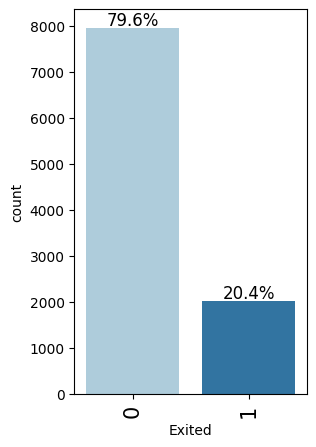

In [ ]:
# checking balance of target feature
labeled_barplot(data,'Exited', perc=True)

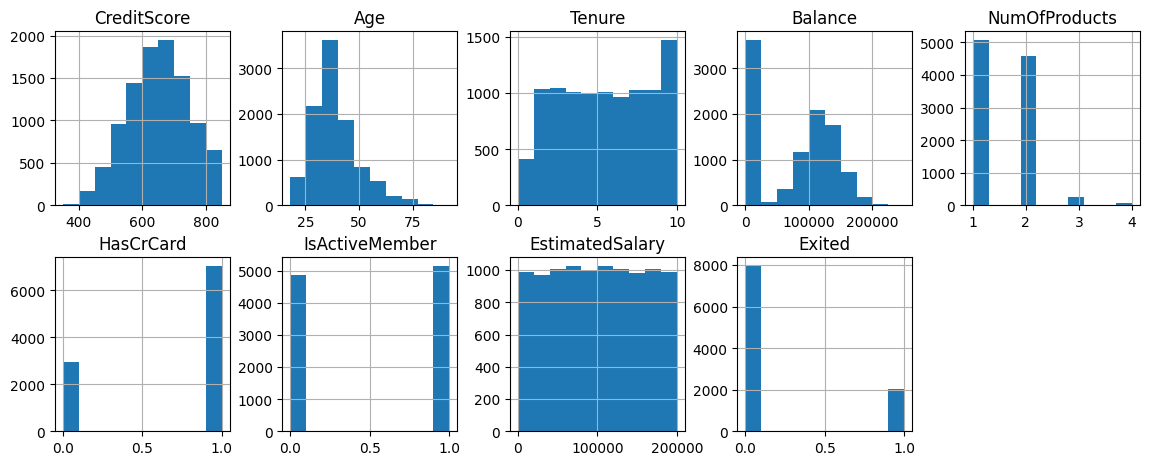

In [ ]:
# histogram for all numeric features
data.hist(figsize=(14, 14), layout=(5, 5));

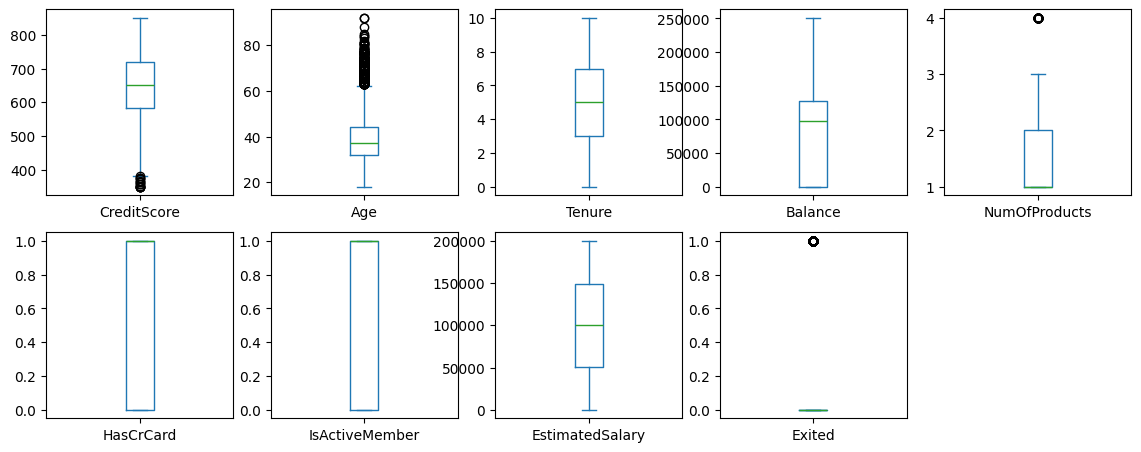

In [ ]:
# box plot for all numeric features
data.plot(kind="box", subplots=True, layout=(5, 5), figsize=(14, 14));

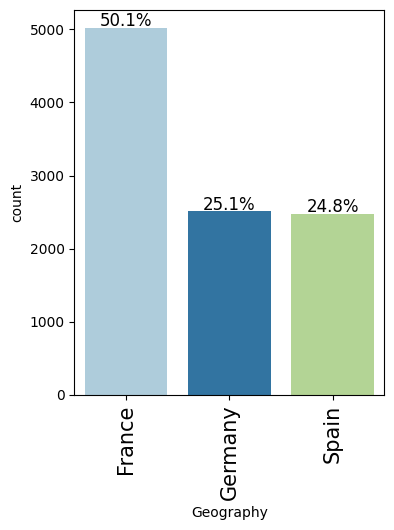

In [ ]:
# reviewing Geography
labeled_barplot(data,'Geography', perc=True)

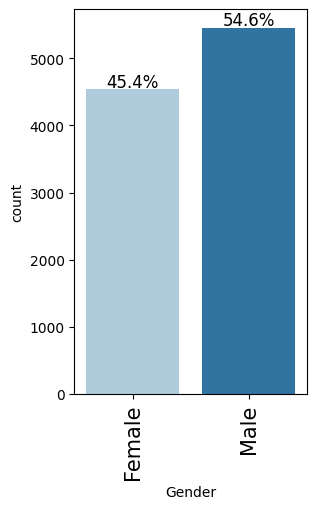

In [ ]:
# reviewing Gender
labeled_barplot(data,'Gender', perc=True)

**Univariate analysis**
<br>
<br>
Observations:
*   CreditScore: Normally distributed, slight left skew.  
*   Age: Right-skewed; most customers are 30–40 years old, some outliers above ~60 years.
*   Tenure: Uniform distribution, with a peak 8~10 years.
*   Balance: Many customers have zero balance.  
*   NumOfProducts: Most have 1 or 2 products; few have 3 or 4.  
*   HasCrCard: most have a credit card.
*   IsActiveMember: roughly the same percentage are active and inactive.
*   EstimatedSalary: Uniformly distributed.
*   Exited: Imbalanced; most did not churn.  
*   50% of the customers are from France, followed by Germany and Spain closely at 25% each.
- Gender of customers is almost distributed equally.

Key Considerations
*   Class Imbalance, treatment may be needed.  
*   Consider the large scale of features like balance, EstimatedSalary.


### 3.2. Bivariate Analysis

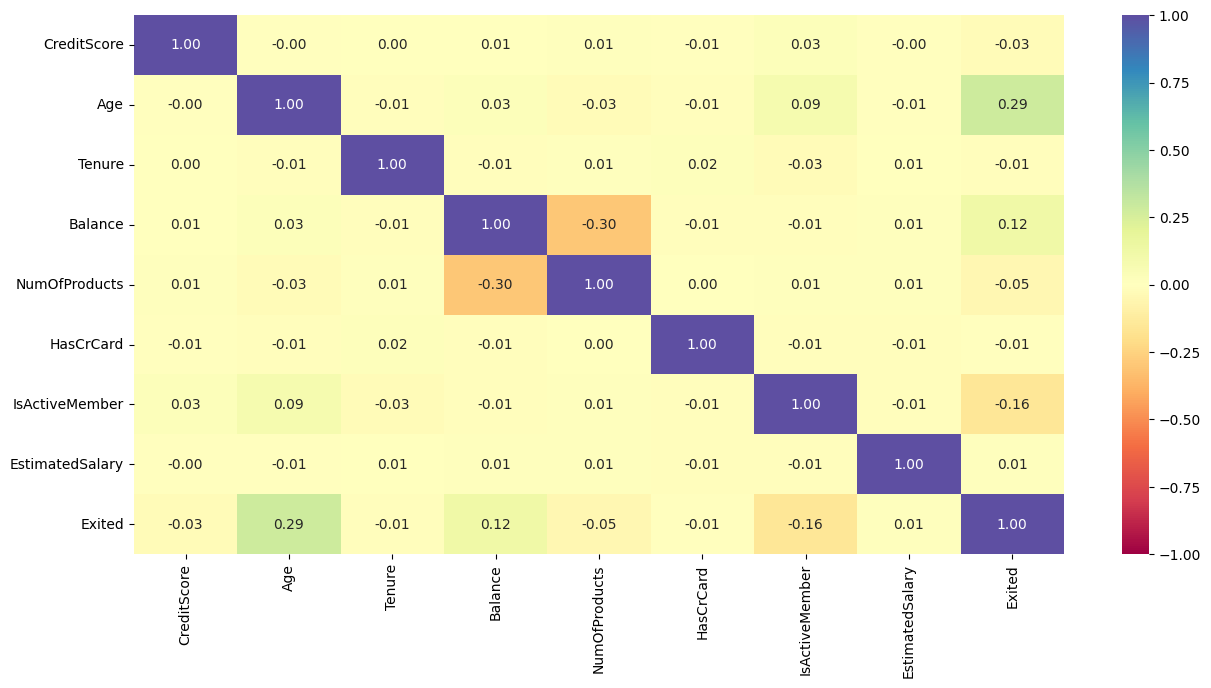

In [ ]:
# heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(data.corr(numeric_only = True), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

Only weak correlations are observed:


*   (Negative) Balance & NumOfProducts. As the NumOfProducts increases, the less Balance the customer has.
*   (Positive) Age & Exited. Perhaps customers with higher age have churned, will need to be investigated further.
*   (Negative) IsActiveMemger & Exited:  more inactive customers are more likely to churn.


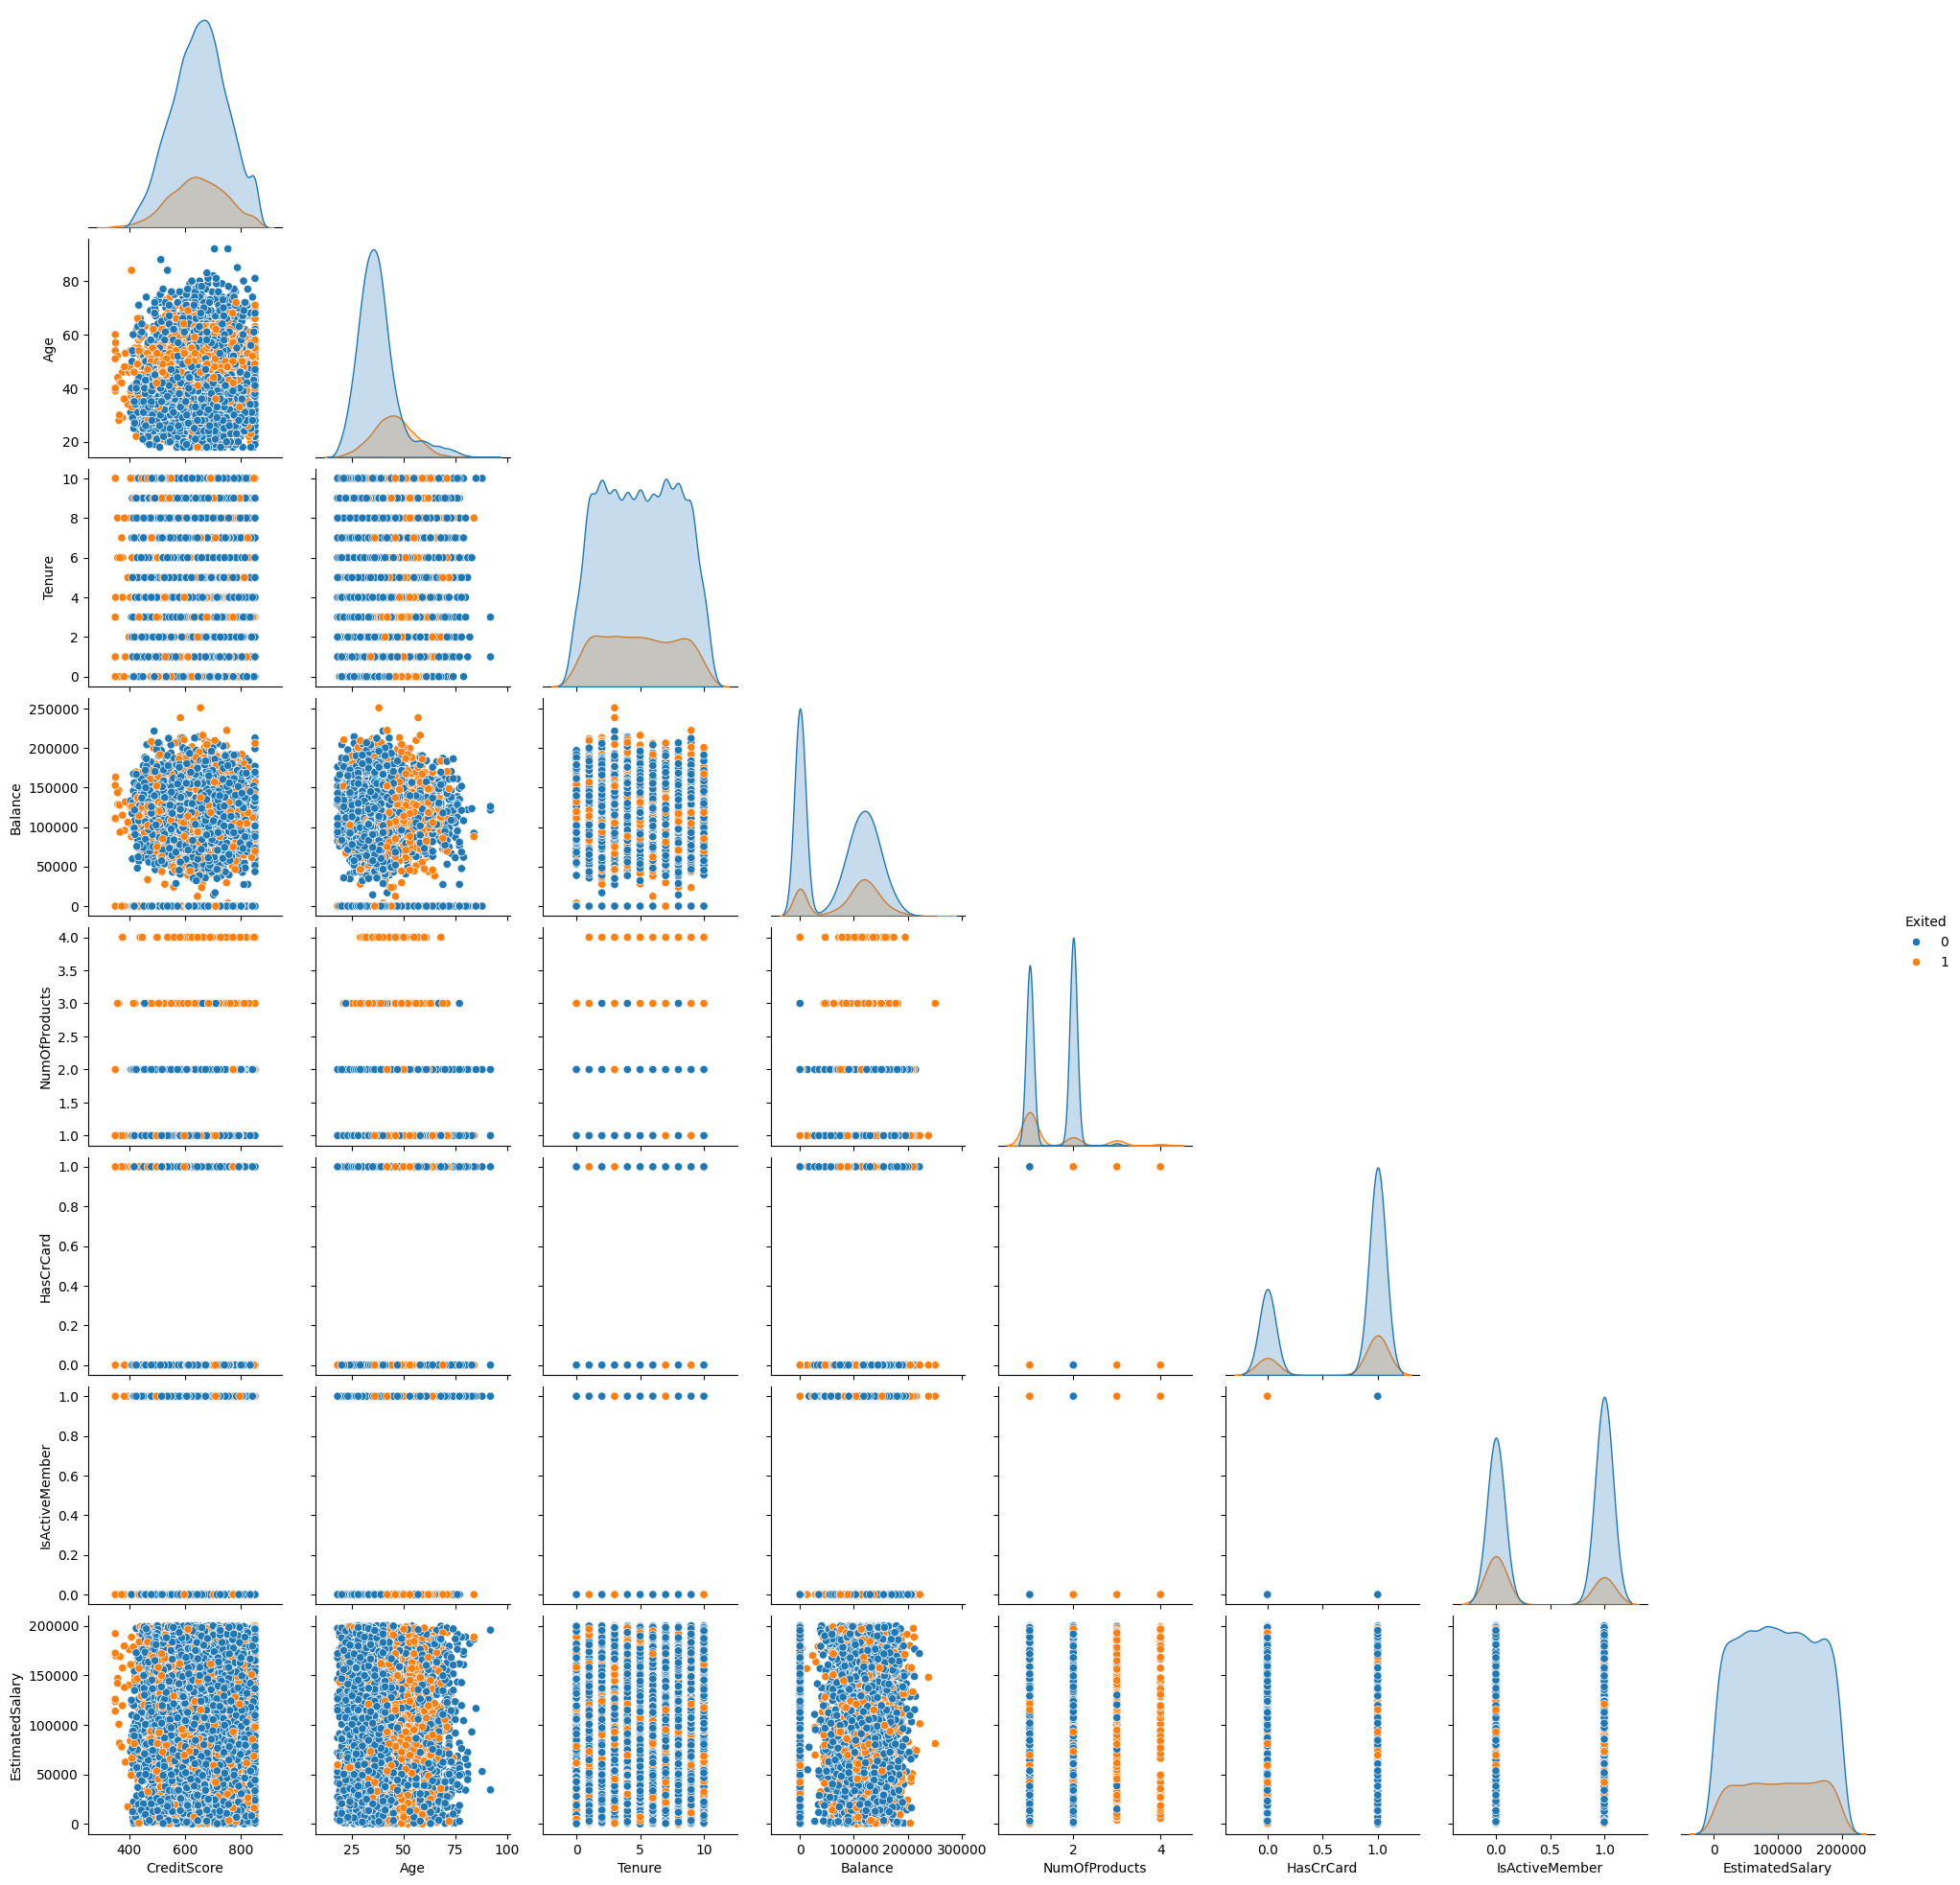

In [ ]:
# pair plot
sns.pairplot(data, hue="Exited", corner=True);

Investigating further a few features: Age, NumOfProducts, IsActiveMember...

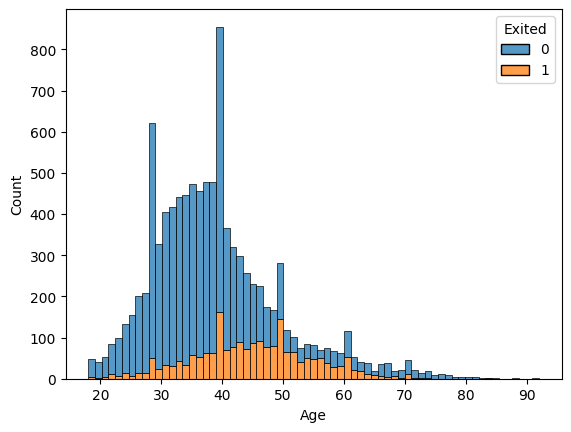

In [ ]:
# Age and Exited
sns.histplot(data=data, x="Age", hue="Exited", multiple="stack");

Exited            0     1    All
NumOfProducts                   
All            7963  2037  10000
1              3675  1409   5084
2              4242   348   4590
3                46   220    266
4                 0    60     60
------------------------------------------------------------------------------------------------------------------------


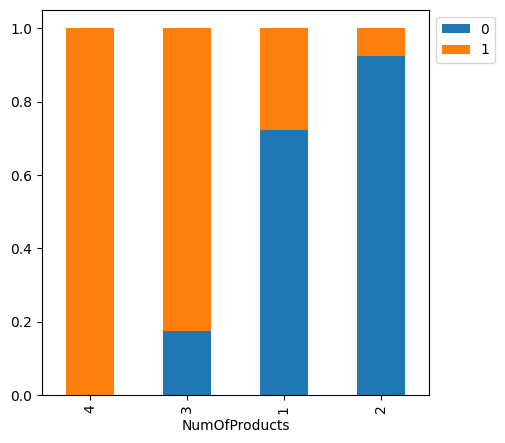

In [ ]:
# NumOfProducts and Exited
stacked_barplot(data, "NumOfProducts", "Exited")

Exited             0     1    All
IsActiveMember                   
All             7963  2037  10000
0               3547  1302   4849
1               4416   735   5151
------------------------------------------------------------------------------------------------------------------------


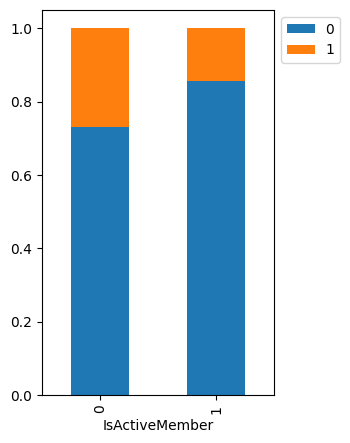

In [ ]:
# IsActiveMember and Exited
stacked_barplot(data, "IsActiveMember", "Exited")

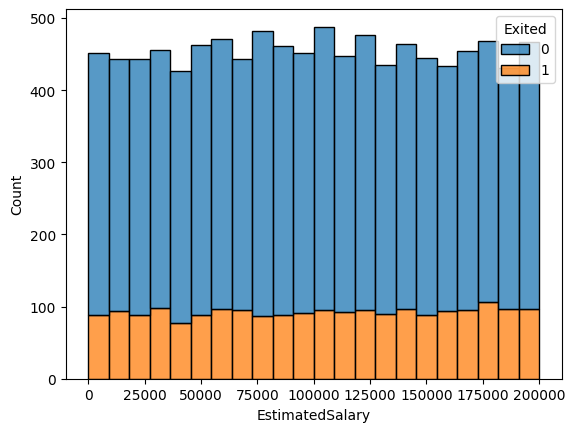

In [ ]:
# EstimatedSalary and Exited
sns.histplot(data=data, x="EstimatedSalary", hue="Exited", multiple="stack");

Exited        0     1    All
HasCrCard                   
All        7963  2037  10000
1          5631  1424   7055
0          2332   613   2945
------------------------------------------------------------------------------------------------------------------------


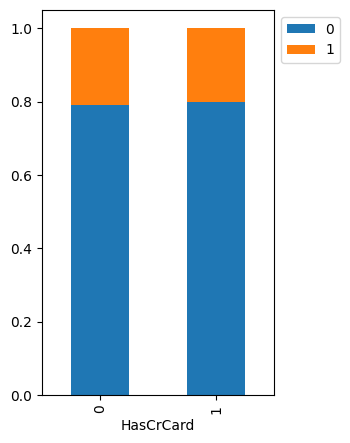

In [ ]:
# HasCrCard and Exited
stacked_barplot(data, "HasCrCard", "Exited")

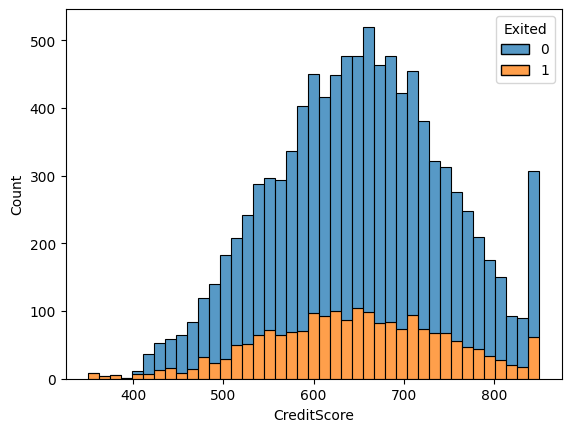

In [ ]:
# CreditScore and Exited
sns.histplot(data=data, x="CreditScore", hue="Exited", multiple="stack");

**Bivariate analysis**
<br>
<br>
Observations:

* Customers between 40~60 have exited more. This seems independent of Balance, CreditScore and EstimatedSalary.
* Customers with 3-4 NumOfProducts have exited more.
* There is a slightly higher count of inactive customers that churned compared to active customers.
* No discernible pattern was observed in additional plots involving features like EstimatedSalary, CreditScore, Balance, HasCrCard

## 4. DATA PREPROCESSING

### 4.1. Outlier detection

No specific treatment will be applied to outliers at the time, as these outliers seem to represent natural variations in customer behavior rather than data anomalies. Instead, these extreme values might provide key insights into attrition risk and customer engagement trends.

The features with most outliers are:
*   Age (359 rows)
*   NumOfProducts (60 rows)

In [ ]:
#https://github.com/vbelz/Outliers_detection/tree/main
#https://github.com/ashrafalaghbari/odc


def identify_plot_outliers(df, columns):
    """
    Identifies and plots outliers in specified columns of a DataFrame using plotly express.

    Args:
        df: The input DataFrame.
        columns: A list of column names to analyze for outliers.
    """

    for col in columns:
        if col not in df.columns:
            print(f"Warning: Column '{col}' not found in DataFrame. Skipping.")
            continue

        if not pd.api.types.is_numeric_dtype(df[col]):
            print(f"Warning: Column '{col}' is not numeric. Skipping.")
            continue

        # Calculate quartiles and IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        # Create the box plot
        plt.figure(figsize=(8, 6))  # Adjust figure size as needed
        sns.boxplot(y=df[col], showmeans=True)
        #sns.swarmplot(y=df[col], color="red", size=3) #show the data points and outliers
        plt.title(f"Box Plot of {col} with Outliers")
        plt.ylabel(col)
        plt.show()

        # Display outliers as a DataFrame
        print(f"Outliers in column '{col}':")
        print(f"Outliers row count is: {outliers.shape[0]}")
        display(outliers)
        print("*"*10)
        print("\n")

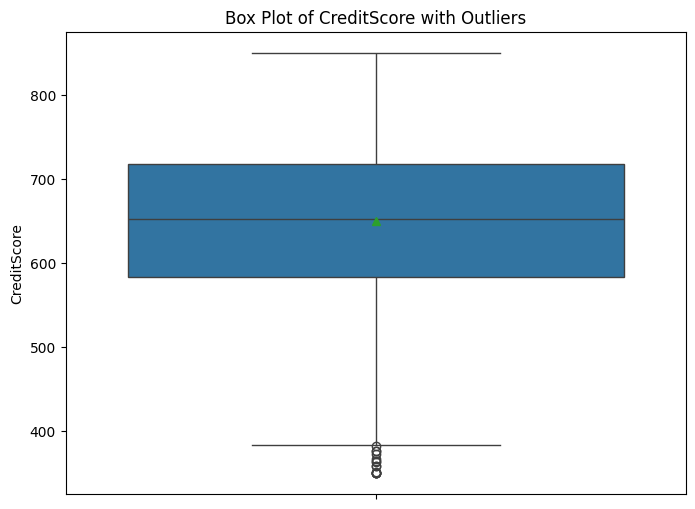

Outliers in column 'CreditScore':
Outliers row count is: 15


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
942,376,France,Female,46,6,0.00,1,1,0,157333.69,1
1193,363,Spain,Female,28,6,146098.43,3,1,0,100615.14,1
1405,359,France,Female,44,6,128747.69,1,1,0,146955.71,1
1631,350,Spain,Male,54,1,152677.48,1,1,1,191973.49,1
1838,350,Germany,Male,39,0,109733.20,2,0,0,123602.11,1
1962,358,Spain,Female,52,8,143542.36,3,1,0,141959.11,1
2473,351,Germany,Female,57,4,163146.46,1,1,0,169621.69,1
2579,365,Germany,Male,30,0,127760.07,1,1,0,81537.85,1
8154,367,Spain,Male,42,6,93608.28,1,1,0,168816.73,1


**********




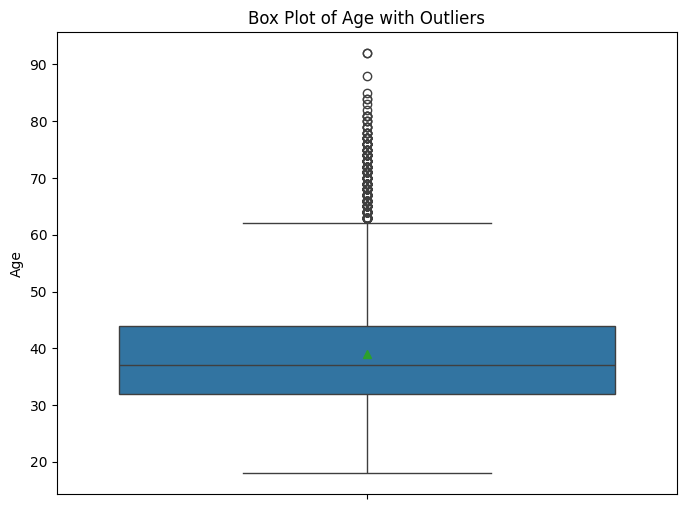

Outliers in column 'Age':
Outliers row count is: 359


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
58,511,Spain,Female,66,4,0.00,1,1,0,1643.11,1
85,652,Spain,Female,75,10,0.00,2,1,1,114675.75,0
104,670,Spain,Female,65,1,0.00,1,1,1,177655.68,1
158,646,France,Female,73,6,97259.25,1,0,1,104719.66,0
181,510,France,Male,65,2,0.00,2,1,1,48071.61,0
...,...,...,...,...,...,...,...,...,...,...,...
9753,656,Germany,Male,68,7,153545.11,1,1,1,186574.68,0
9765,445,France,Male,64,2,136770.67,1,0,1,43678.06,0
9832,595,Germany,Female,64,2,105736.32,1,1,1,89935.73,1
9894,521,France,Female,77,6,0.00,2,1,1,49054.10,0


**********




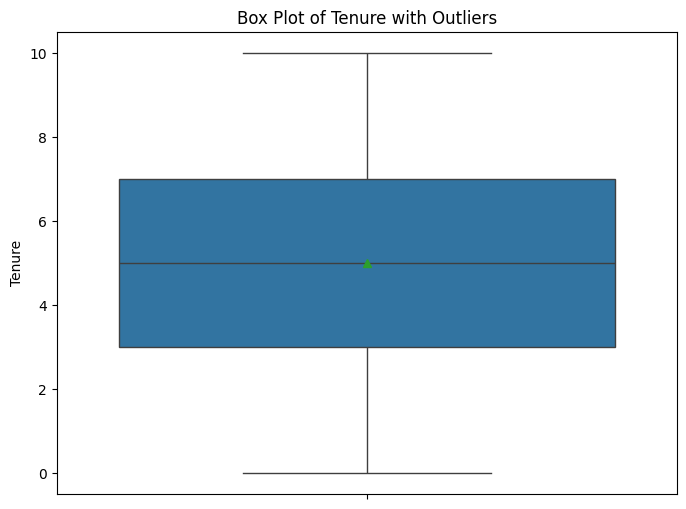

Outliers in column 'Tenure':
Outliers row count is: 0


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


**********




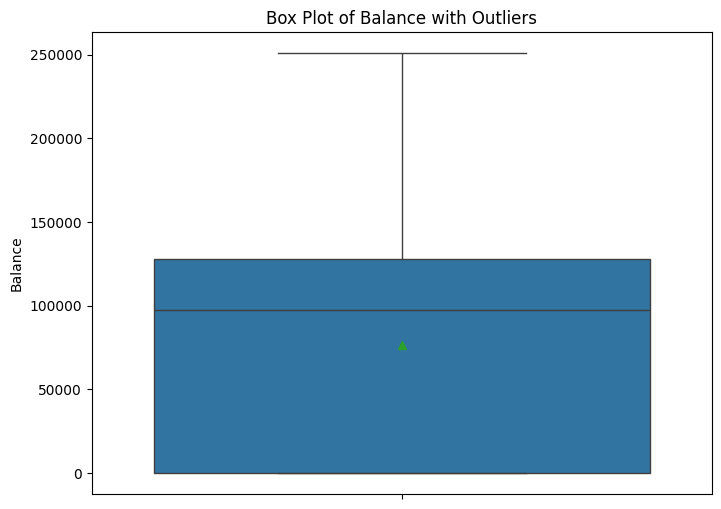

Outliers in column 'Balance':
Outliers row count is: 0


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


**********




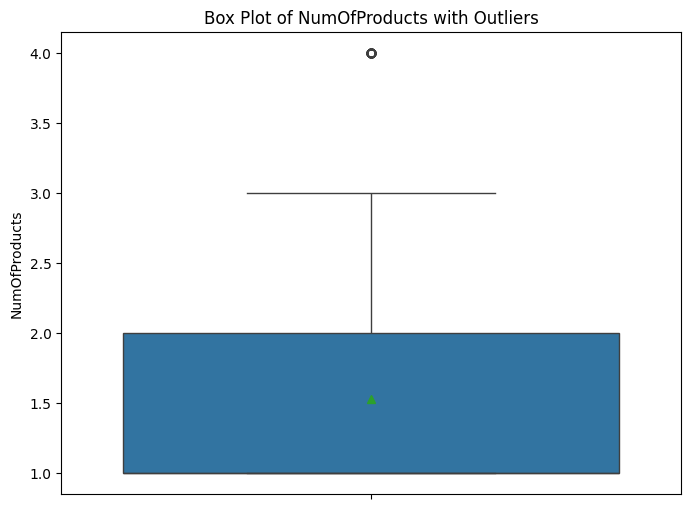

Outliers in column 'NumOfProducts':
Outliers row count is: 60


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
70,738,Germany,Male,58,2,133745.44,4,1,0,28373.86,1
1254,628,France,Female,46,1,46870.43,4,1,0,31272.14,1
1469,819,Germany,Female,49,1,120656.86,4,0,0,166164.30,1
1488,596,Spain,Male,30,6,121345.88,4,1,0,41921.75,1
1701,792,France,Male,50,9,0.00,4,1,1,194700.81,1
1876,640,Germany,Male,39,9,131607.28,4,0,1,6981.43,1
2124,704,France,Male,32,7,127785.17,4,0,0,184464.70,1
2196,773,Germany,Male,47,2,118079.47,4,1,1,143007.49,1
2285,630,Germany,Male,50,3,129370.91,4,1,1,47775.34,1


**********




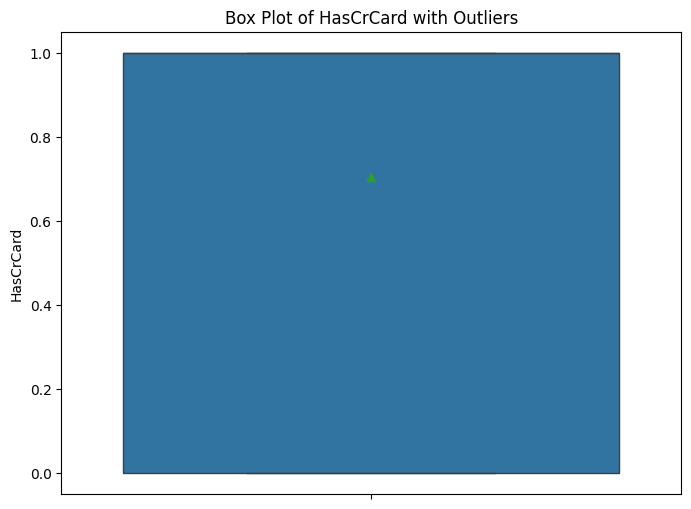

Outliers in column 'HasCrCard':
Outliers row count is: 0


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


**********




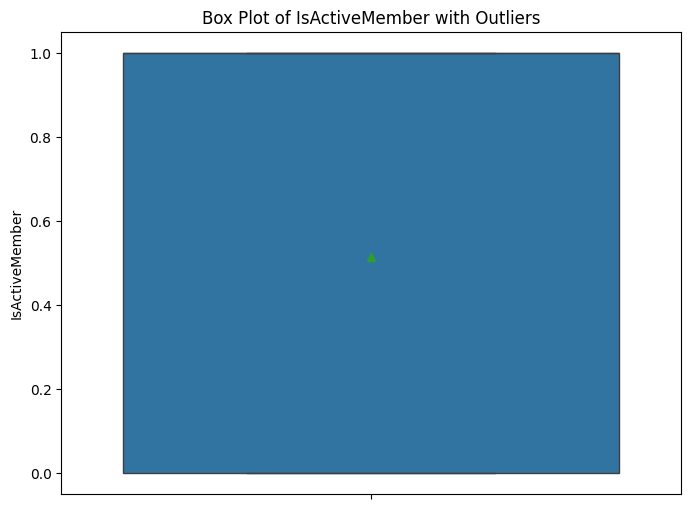

Outliers in column 'IsActiveMember':
Outliers row count is: 0


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


**********




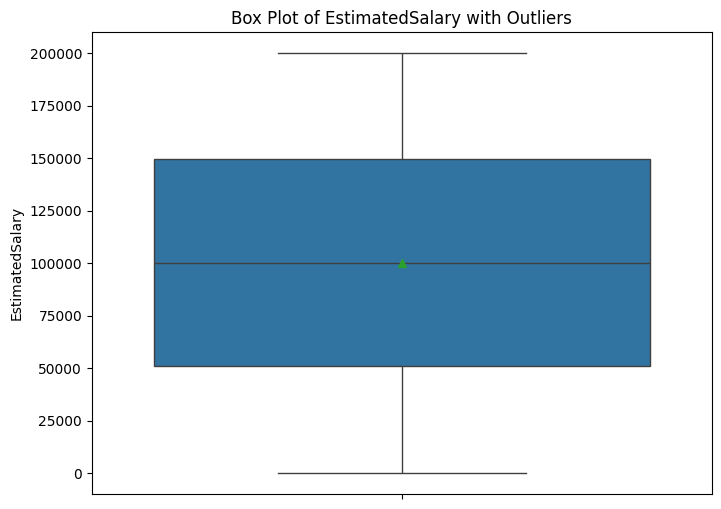

Outliers in column 'EstimatedSalary':
Outliers row count is: 0


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


**********




In [ ]:
cols = list(data.select_dtypes(include=["float64", "int64"]))
cols.remove("Exited")
identify_plot_outliers(data, cols)

### 4.2. Dummy Variable Creation

In [ ]:
# converting object(string) columns into dummy variables
data = pd.get_dummies(data,columns=data.select_dtypes(include=["object"]).columns.tolist(),drop_first=True)
data = data.astype(float)
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619.0,42.0,2.0,0.00,1.0,1.0,1.0,101348.88,1.0,0.0,0.0,0.0
1,608.0,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58,0.0,0.0,1.0,0.0
2,502.0,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57,1.0,0.0,0.0,0.0
3,699.0,39.0,1.0,0.00,2.0,0.0,0.0,93826.63,0.0,0.0,0.0,0.0
4,850.0,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10,0.0,0.0,1.0,0.0


### 4.3. Train-validation-test Split

Avoiding Data Leakage:
*   Split data before any transformations.
*   Scaling:
  * grab a copy of X_train before scaling.
  * fit_transform performed only on the train split. transform performed only on the val/test split.
*   SMOTE:
  * apply on the unscaled training set.
  * scale the SMOTE set using its own scaler.
  * SMOTE-generated samples may be affected by the mean and variance of the entire training set (instead of being properly scaled after creation).
*   Data dictionary was evaluated and no feature was identified that could result in data leakage. Assuming that 'Balance', 'isActiveMember', 'NumOfProducts' are features that represent historical and not post-churn data, as to avoid data-leakage thru features not available at the time of prediction.
*   Missing value Imputation: no needed as no missing values were found.

In [ ]:
X = data.drop(['Exited'],axis=1) # removing target feature
y = data['Exited'] # target feature only

In [ ]:
# Splitting data into training, validation and test set: 70/15/15

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=gbl_random_seed, stratify=y, shuffle=True)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=gbl_random_seed, stratify=y_temp, shuffle=True)

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7000, 11) (1500, 11) (1500, 11)
(7000,) (1500,) (1500,)


In [ ]:
# creating a copy of X_train before scaling to avoid data leakage
X_train_unscaled = X_train.copy()

### 4.4. Scaling data

scaling the data on original dataset (no over/under sampling)

In [ ]:
scale_cols = ["CreditScore","Age","Tenure","Balance","EstimatedSalary"]

# creating an instance of the standard scaler
sc = StandardScaler()

# to avoid data leakage, fit_transform on train split only, transform on val and test splits.
X_train[scale_cols] = sc.fit_transform(X_train[scale_cols])
X_val[scale_cols] = sc.transform(X_val[scale_cols])
X_test[scale_cols] = sc.transform(X_test[scale_cols])

### 4.5. Creating the balanced training dataset by using SMOTE

In [ ]:
print('Before oversampling, the shape of train_X: {}'.format(X_train_unscaled.shape))
print('Before oversampling, the shape of train_y: {} \n'.format(y_train.shape))

sm  = SMOTE(random_state=gbl_random_seed)

# using X_train_unscaled to avoid data leakage
X_train_smote, y_train_smote= sm.fit_resample(X_train_unscaled, y_train)

print('After oversampling, the shape of train_X: {}'.format(X_train_smote.shape))
print('After oversampling, the shape of train_y: {} \n'.format(y_train_smote.shape))

Before oversampling, the shape of train_X: (7000, 11)
Before oversampling, the shape of train_y: (7000,) 

After oversampling, the shape of train_X: (11148, 11)
After oversampling, the shape of train_y: (11148,) 



scaling the data on smote dataset

In [ ]:
# scaling the smote dataset using its own scaler to avoid data leakage
sc_smote = StandardScaler()
X_train_smote[scale_cols] = sc_smote.fit_transform(X_train_smote[scale_cols])

### 4.6. Class weights (to be used by models not using the SMOTE training dataset)

In [ ]:
# Calculate class weights for imbalanced dataset
cw = (y_train.shape[0]) / np.bincount(y_train)

# Create a dictionary mapping class indices to their respective class weights
gbl_class_weight = {}
for i in range(cw.shape[0]):
    gbl_class_weight[i] = cw[i]

gbl_class_weight

{0: 1.2558306422676713, 1: 4.908835904628331}

## 5. MODEL BUILDING

Given the business problem, the most appropriate metric would be ***Recall***, because it prioritizes minimizing false negatives, that is, predicted that a customer will not churn, but the customer does churn. Identifying customers at risk of churn is crucial for the bank to take action.

### 5.1. Model building functions

#### 5.1.1. create and train NN

In [ ]:
def ann_create_and_train(
    hidden_layers_config,
    learning_rate,
    optimizer_type,
    batch_size,
    epochs,
    X_train,
    y_train,
    dropout_rates=None,
    metrics=['recall'],
    random_seed=gbl_random_seed,
    verbose=gbl_verbose,
    class_weight=None,
):
    """
    Creates and trains a neural network model with optional dropout layers.
    *CURRENTLY HARDCODED*:
      1. input_dim=X_train.shape[1]
      2. Output layer: 1 neuron with sigmoid activation.
      3. Loss function: binary_crossentropy
      4. X_val and y_val are global variables.

    Args:
        hidden_layers_config (list): List of dictionaries specifying the
            number of neurons and activation function for each hidden layer.
        learning_rate (float): Learning rate for the optimizer.
        optimizer_type (str): Type of optimizer ('SGD', 'Adam').
        batch_size (int): Batch size for training.
        epochs (int): Number of epochs for training.
        X_train (np.array): Training data features.
        y_train (np.array): Training data labels.
        dropout_rates (list): List of dropout rates for each hidden layer.
        metrics (list): List of metrics to track.
            e.g., ['Recall', 'Accuracy', 'Precision', 'F1Score']
        random_seed (int): Random seed for reproducibility.
        verbose (int): Verbosity level, default to 1.

    Returns:
        tuple: A tuple containing the trained model and the training history.
    """
    backend.clear_session()
    keras.utils.set_random_seed(random_seed)

    model = Sequential()

    # Input layer
    if hidden_layers_config[0]["activation"].lower() == "leakyrelu":
      model.add(
          Dense(
              hidden_layers_config[0]["neurons"],
              input_dim=X_train.shape[1], activation=tf.keras.layers.LeakyReLU(alpha=0.01)
          )
      )


    else:
      model.add(
          Dense(
              hidden_layers_config[0]["neurons"],
              activation=hidden_layers_config[0]["activation"],
              input_dim=X_train.shape[1],
          )
      )

    # Hidden layers
    for i, layer_config in enumerate(hidden_layers_config[1:]):
        if layer_config["activation"].lower() == "leakyrelu":
          model.add(
              Dense(layer_config["neurons"], activation=tf.keras.layers.LeakyReLU(alpha=0.01))
          )

        else:
          model.add(
              Dense(layer_config["neurons"], activation=layer_config["activation"])
          )
        if dropout_rates and len(dropout_rates) == len(hidden_layers_config[1:]):
            model.add(Dropout(dropout_rates[i]))


    # Output layer
    model.add(Dense(1, activation="sigmoid"))

    # Optimizer selection
    if optimizer_type.lower() == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_type.lower() == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer type: {optimizer_type}")

    # Convert string metric names to Keras metric objects
    keras_metrics = []
    for metric_name in metrics:
      if metric_name.lower() == "recall":
        keras_metrics.append(keras.metrics.Recall(name='recall'))
      elif metric_name.lower() == "accuracy":
        keras_metrics.append(keras.metrics.Accuracy(name='accuracy'))
      elif metric_name.lower() == "precision":
          keras_metrics.append(keras.metrics.Precision(name='precision'))
      elif metric_name.lower() == "f1score":
          #note that f1score is not directly available in keras, it needs to be created
          #it also needs to have a different name
          def f1_score(y_true, y_pred):
            true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
            predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
            possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
            precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
            recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
            return 2*((precision*recall)/(precision+recall+tf.keras.backend.epsilon()))

          keras_metrics.append(f1_score)

      else:
        raise ValueError(f"Unsupported metric: {metric_name}")

    # Compile the model
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=keras_metrics)

    model.summary()

    start = time.time()
    # Train the model
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        verbose=verbose,
        class_weight=class_weight
    )
    end = time.time()
    print(f"Time taken: {np.round(end - start,3)} seconds")

    return model, history

#### 5.1.2. NN reports

In [ ]:
def make_confusion_matrix(actual_targets, predicted_targets):
    """
    To plot the confusion_matrix with percentages

    actual_targets: actual target (dependent) variable values
    predicted_targets: predicted target (dependent) variable values
    """
    cm = confusion_matrix(actual_targets, predicted_targets)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(cm.shape[0], cm.shape[1])

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

In [ ]:
def ann_reports(model_name, model, history, X_train, y_train):
  """
  displays and prints several reports and plots for the provided parameters.
  NOTE: global X_val and y_val will be used.

  Args:
    model_name: name for the model
    model: nn model
    history: history data for the model
    X_train: training data features
    y_train: training data labels

  """


  # ========================================
  #Plotting Train Loss vs Validation Loss

  display(Markdown("**Loss function**"))

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()


  # ========================================
  # Plotting Train recall vs Validation recall

  display(Markdown("**Recall**"))

  plt.plot(history.history['recall'])
  plt.plot(history.history['val_recall'])
  plt.title('model recall')
  plt.ylabel('Recall')
  plt.xlabel('Epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()


  print ("Predicting the results using best as a threshold - Train")
  y_train_pred = model.predict(X_train)
  y_train_pred = (y_train_pred > 0.5)
  y_train_pred

  print ("Predicting the results using best as a threshold - Val")
  y_val_pred = model.predict(X_val)
  y_val_pred = (y_val_pred > 0.5)
  y_val_pred


  # Calculate all metrics
  train_recall = recall_score(y_train, y_train_pred)
  train_precision = precision_score(y_train, y_train_pred)
  train_accuracy = accuracy_score(y_train, y_train_pred)
  train_f1 = f1_score(y_train, y_train_pred)

  val_recall = recall_score(y_val, y_val_pred)
  val_precision = precision_score(y_val, y_val_pred)
  val_accuracy = accuracy_score(y_val, y_val_pred)
  val_f1 = f1_score(y_val, y_val_pred)

  # saving the metrics in the dataframe that will be used to compare
  train_metric_df.loc[model_name] = [train_recall, train_precision, train_accuracy, train_f1]
  val_metric_df.loc[model_name] = [val_recall, val_precision, val_accuracy, val_f1]


  # ========================================
  display(Markdown("**Classification report**"))

  print("classification report on training set")
  cr = classification_report(y_train, y_train_pred)
  print(cr)

  print("classification report on val set")
  cr=classification_report(y_val, y_val_pred)
  print(cr)


  # ========================================
  display(Markdown("**Confusion matrix**"))
  print("Confusion matrix: training")
  make_confusion_matrix(y_train, y_train_pred)

  print("Confusion matrix: val")
  make_confusion_matrix(y_val, y_val_pred)

### 5.2. (model_0) NN with SGD optimizer

In [ ]:
# Parameters for the model

optimizer_type = "sgd"
hidden_layers_config = gbl_hidden_layers_config


# Create and train the model
model_0, history_0 = ann_create_and_train(
    optimizer_type = optimizer_type,
    learning_rate = gbl_learning_rate,
    batch_size = gbl_batch_size,
    epochs = gbl_epochs,
    metrics = gbl_metrics,
    hidden_layers_config = hidden_layers_config,
    X_train = X_train,
    y_train = y_train,
    class_weight = gbl_class_weight
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 929 (3.63 KB)

 Trainable params: 929 (3.63 KB)

 Non-trainable params: 0 (0.00 B)

Time taken: 36.6 seconds


**Loss function**

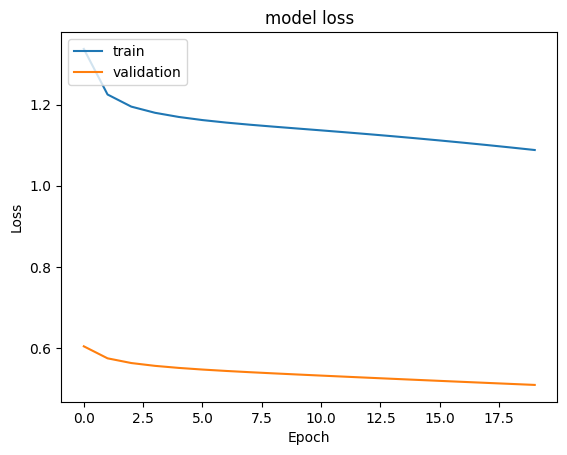

**Recall**

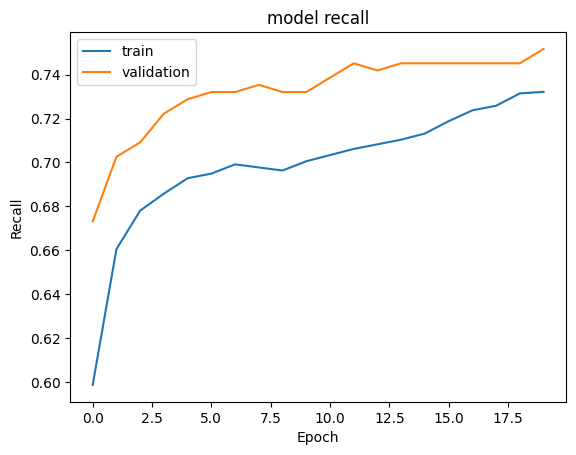

Predicting the results using best as a threshold - Train
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predicting the results using best as a threshold - Val
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


**Classification report**

classification report on training set
              precision    recall  f1-score   support

         0.0       0.91      0.74      0.82      5574
         1.0       0.41      0.71      0.52      1426

    accuracy                           0.73      7000
   macro avg       0.66      0.73      0.67      7000
weighted avg       0.81      0.73      0.76      7000

classification report on val set
              precision    recall  f1-score   support

         0.0       0.92      0.76      0.83      1194
         1.0       0.44      0.75      0.56       306

    accuracy                           0.76      1500
   macro avg       0.68      0.75      0.69      1500
weighted avg       0.82      0.76      0.78      1500



**Confusion matrix**

Confusion matrix: training


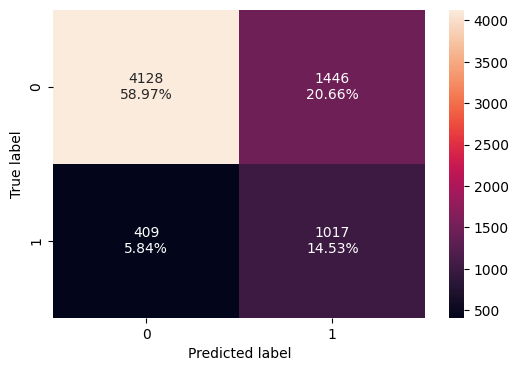

Confusion matrix: val


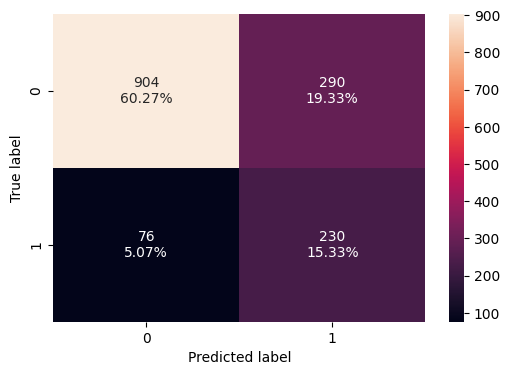

In [ ]:
ann_reports("NN with SGD", model_0, history_0, X_train, y_train)

## 6. MODEL PERFORMANCE IMPROVEMENT

### 6.1. (model_1) NN with Adam optimizer

In [ ]:
# Parameters for the model

optimizer_type = "adam"
hidden_layers_config = gbl_hidden_layers_config

# Create and train the model
model_1, history_1 = ann_create_and_train(
    optimizer_type = optimizer_type,
    learning_rate = gbl_learning_rate,
    batch_size = gbl_batch_size,
    epochs = gbl_epochs,
    metrics = gbl_metrics,
    hidden_layers_config = hidden_layers_config,
    X_train = X_train,
    y_train = y_train,
    class_weight = gbl_class_weight
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 929 (3.63 KB)

 Trainable params: 929 (3.63 KB)

 Non-trainable params: 0 (0.00 B)

Time taken: 39.397 seconds


**Loss function**

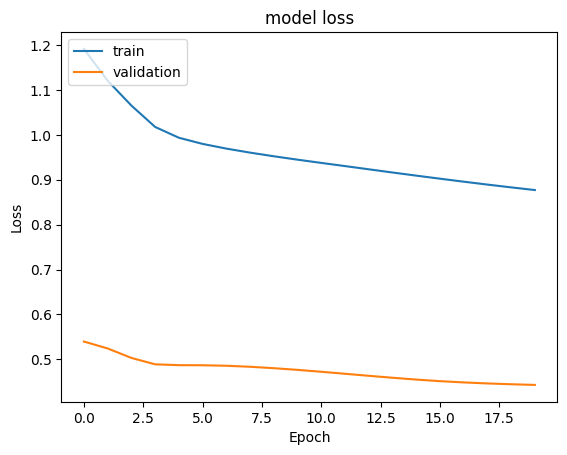

**Recall**

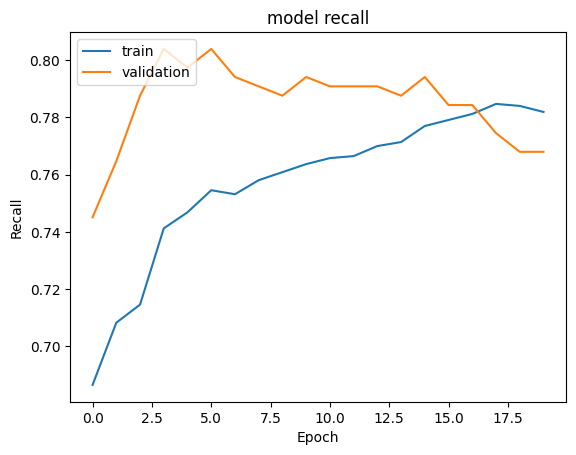

Predicting the results using best as a threshold - Train
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predicting the results using best as a threshold - Val
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


**Classification report**

classification report on training set
              precision    recall  f1-score   support

         0.0       0.94      0.81      0.87      5574
         1.0       0.52      0.78      0.62      1426

    accuracy                           0.81      7000
   macro avg       0.73      0.80      0.75      7000
weighted avg       0.85      0.81      0.82      7000

classification report on val set
              precision    recall  f1-score   support

         0.0       0.93      0.81      0.87      1194
         1.0       0.51      0.77      0.61       306

    accuracy                           0.80      1500
   macro avg       0.72      0.79      0.74      1500
weighted avg       0.85      0.80      0.82      1500



**Confusion matrix**

Confusion matrix: training


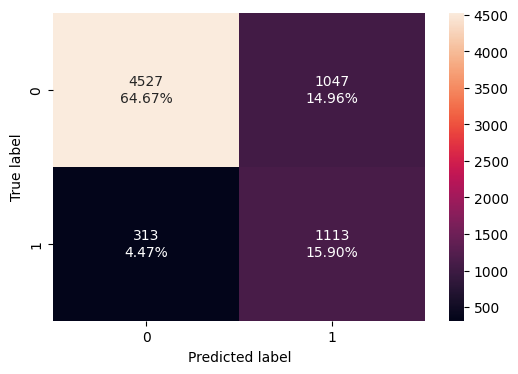

Confusion matrix: val


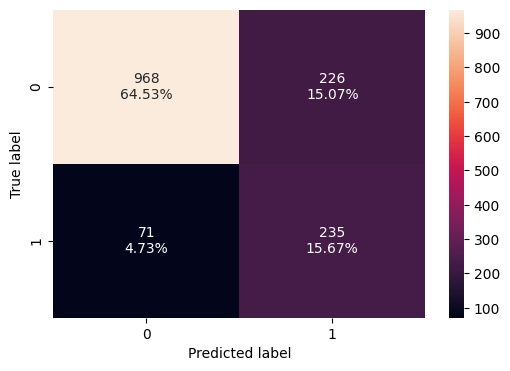

In [ ]:
ann_reports("NN with Adam", model_1, history_1, X_train, y_train)

### 6.2. (model_2) NN Adam optimizer and dropout

In [ ]:
# Parameters for the model

optimizer_type = "adam"
hidden_layers_config = gbl_hidden_layers_config
dropout_rates = [0.3, 0.2] # dropout rates for each hidden layer

# Create and train the model
model_2, history_2 = ann_create_and_train(
    optimizer_type = optimizer_type,
    learning_rate = gbl_learning_rate,
    batch_size = gbl_batch_size,
    epochs = gbl_epochs,
    metrics = gbl_metrics,
    hidden_layers_config = hidden_layers_config,
    X_train = X_train,
    y_train = y_train,
    dropout_rates = dropout_rates,
    class_weight = gbl_class_weight
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 929 (3.63 KB)

 Trainable params: 929 (3.63 KB)

 Non-trainable params: 0 (0.00 B)

Time taken: 39.931 seconds


**Loss function**

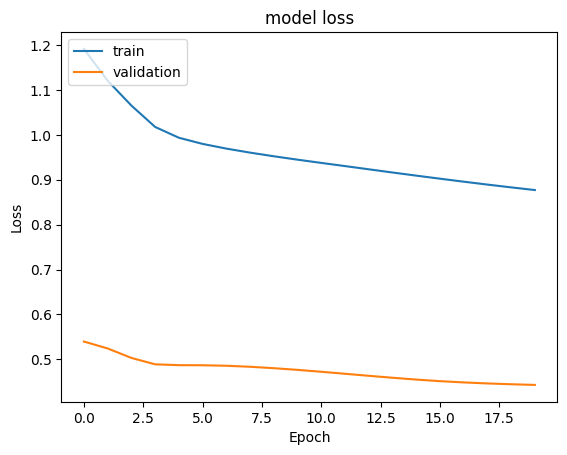

**Recall**

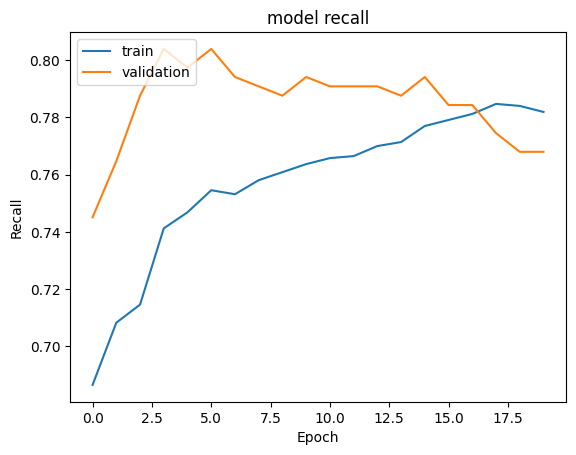

Predicting the results using best as a threshold - Train
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predicting the results using best as a threshold - Val
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


**Classification report**

classification report on training set
              precision    recall  f1-score   support

         0.0       0.94      0.81      0.87      5574
         1.0       0.52      0.78      0.62      1426

    accuracy                           0.81      7000
   macro avg       0.73      0.80      0.75      7000
weighted avg       0.85      0.81      0.82      7000

classification report on val set
              precision    recall  f1-score   support

         0.0       0.93      0.81      0.87      1194
         1.0       0.51      0.77      0.61       306

    accuracy                           0.80      1500
   macro avg       0.72      0.79      0.74      1500
weighted avg       0.85      0.80      0.82      1500



**Confusion matrix**

Confusion matrix: training


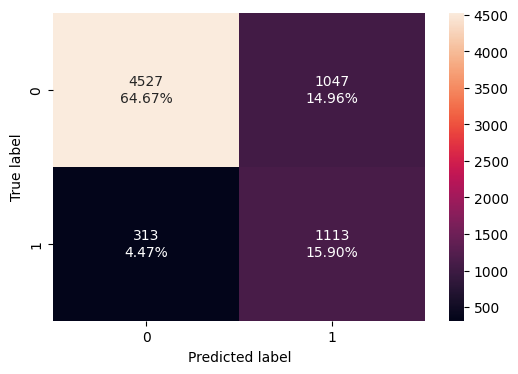

Confusion matrix: val


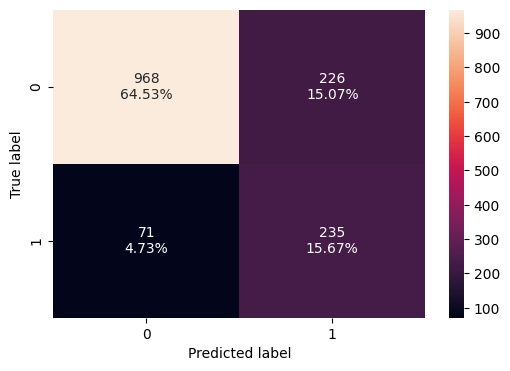

In [ ]:
ann_reports("NN with Adam & Dropout", model_2, history_2, X_train, y_train)

### 6.3. (model_3) NN with balanced (SMOTE) data and SGD optimizer

In [ ]:
# Parameters for the model

optimizer_type = "sgd"

hidden_layers_config = gbl_hidden_layers_config

# Create and train the model
model_3, history_3 = ann_create_and_train(
    optimizer_type = optimizer_type,
    learning_rate = gbl_learning_rate,
    batch_size = gbl_batch_size,
    epochs = gbl_epochs,
    metrics = gbl_metrics,
    hidden_layers_config = hidden_layers_config,
    X_train = X_train_smote, # smote data is sent for training
    y_train = y_train_smote, # smote data is sent for training
    class_weight = None # no class weight to be used since we are using upsampled dataset
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 929 (3.63 KB)

 Trainable params: 929 (3.63 KB)

 Non-trainable params: 0 (0.00 B)

Time taken: 60.871 seconds


**Loss function**

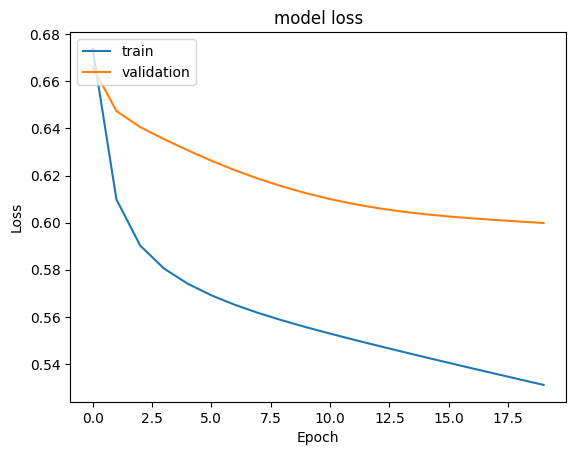

**Recall**

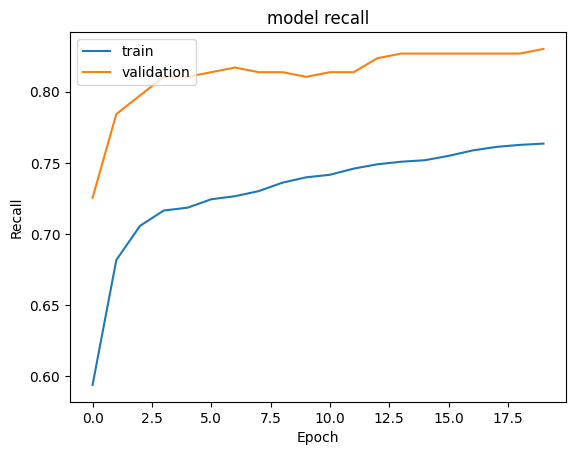

Predicting the results using best as a threshold - Train
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predicting the results using best as a threshold - Val
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


**Classification report**

classification report on training set
              precision    recall  f1-score   support

         0.0       0.76      0.71      0.73      5574
         1.0       0.73      0.77      0.75      5574

    accuracy                           0.74     11148
   macro avg       0.74      0.74      0.74     11148
weighted avg       0.74      0.74      0.74     11148

classification report on val set
              precision    recall  f1-score   support

         0.0       0.93      0.62      0.74      1194
         1.0       0.36      0.83      0.50       306

    accuracy                           0.66      1500
   macro avg       0.65      0.72      0.62      1500
weighted avg       0.82      0.66      0.69      1500



**Confusion matrix**

Confusion matrix: training


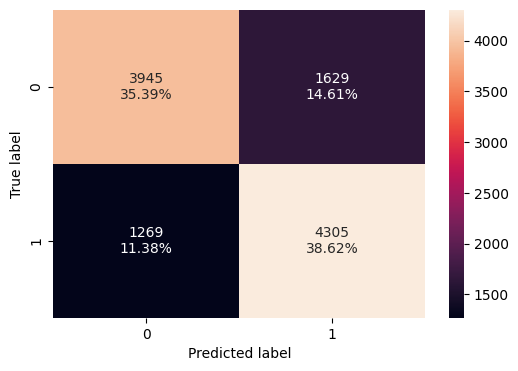

Confusion matrix: val


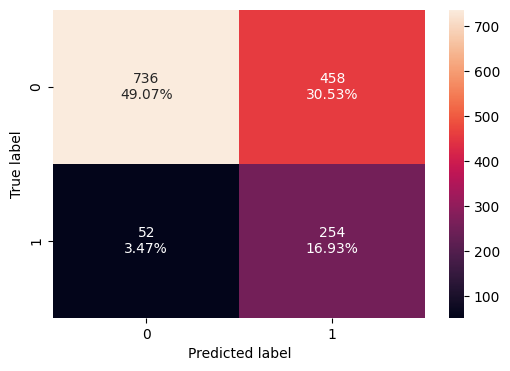

In [ ]:
ann_reports("NN with SMOTE & SGD", model_3, history_3, X_train_smote, y_train_smote)

### 6.4. (model_4) NN with balanced (SMOTE) data and Adam optimizer

In [ ]:
# Parameters for the model

optimizer_type = "adam"
hidden_layers_config = gbl_hidden_layers_config

# Create and train the model
model_4, history_4 = ann_create_and_train(
    optimizer_type = optimizer_type,
    learning_rate = gbl_learning_rate,
    batch_size = gbl_batch_size,
    epochs = gbl_epochs,
    metrics = gbl_metrics,
    hidden_layers_config = hidden_layers_config,
    X_train = X_train_smote, # smote data is sent for training
    y_train = y_train_smote, # smote data is sent for training
    class_weight = None # no class weight to be used since we are using upsampled dataset
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 929 (3.63 KB)

 Trainable params: 929 (3.63 KB)

 Non-trainable params: 0 (0.00 B)

Time taken: 48.401 seconds


**Loss function**

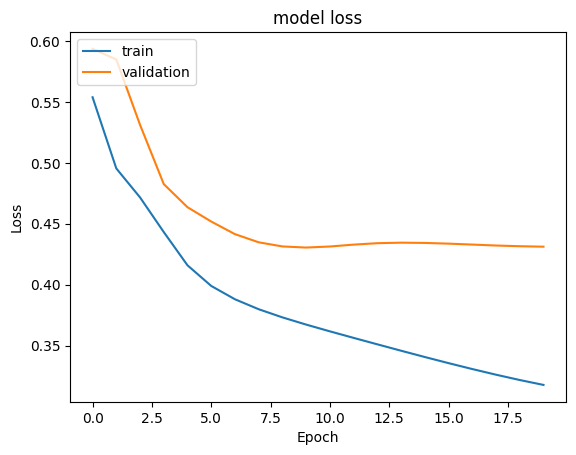

**Recall**

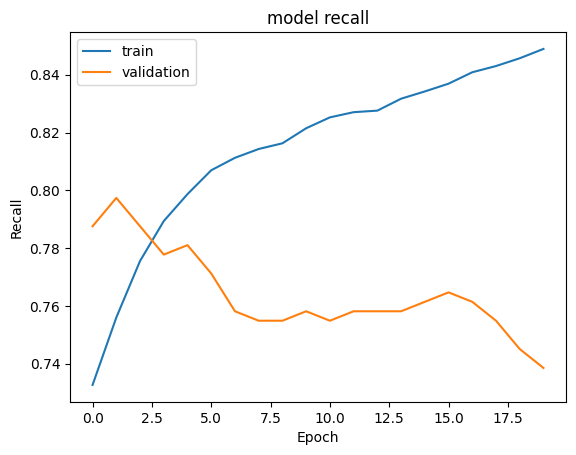

Predicting the results using best as a threshold - Train
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predicting the results using best as a threshold - Val
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


**Classification report**

classification report on training set
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.86      5574
         1.0       0.86      0.87      0.86      5574

    accuracy                           0.86     11148
   macro avg       0.86      0.86      0.86     11148
weighted avg       0.86      0.86      0.86     11148

classification report on val set
              precision    recall  f1-score   support

         0.0       0.92      0.82      0.87      1194
         1.0       0.51      0.74      0.61       306

    accuracy                           0.80      1500
   macro avg       0.72      0.78      0.74      1500
weighted avg       0.84      0.80      0.82      1500



**Confusion matrix**

Confusion matrix: training


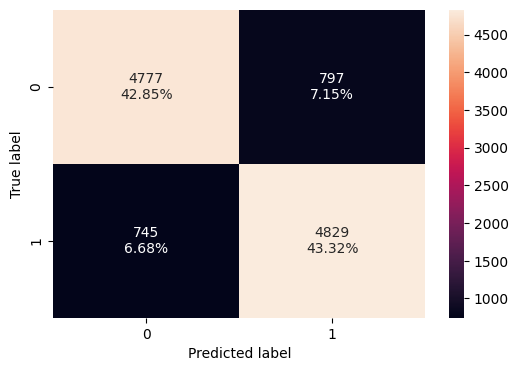

Confusion matrix: val


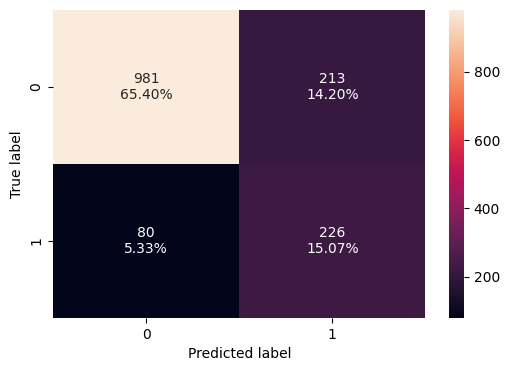

In [ ]:
ann_reports("NN with SMOTE & Adam", model_4, history_4, X_train_smote, y_train_smote)

### 6.5. (model_5) NN with balanced (SMOTE) data, Adam, and Dropout

In [ ]:
# Parameters for the model

optimizer_type = "adam"
hidden_layers_config = gbl_hidden_layers_config
dropout_rates = [0.3, 0.2] # dropout rates for each hidden layer

# Create and train the model
model_5, history_5 = ann_create_and_train(
    optimizer_type = optimizer_type,
    learning_rate = gbl_learning_rate,
    batch_size = gbl_batch_size,
    epochs = gbl_epochs,
    metrics = gbl_metrics,
    hidden_layers_config = hidden_layers_config,
    X_train = X_train_smote, # smote data is sent for training
    y_train = y_train_smote, # smote data is sent for training
    dropout_rates = dropout_rates,
    class_weight = None # no class weight to be used since we are using upsampled dataset
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 929 (3.63 KB)

 Trainable params: 929 (3.63 KB)

 Non-trainable params: 0 (0.00 B)

Time taken: 55.503 seconds


**Loss function**

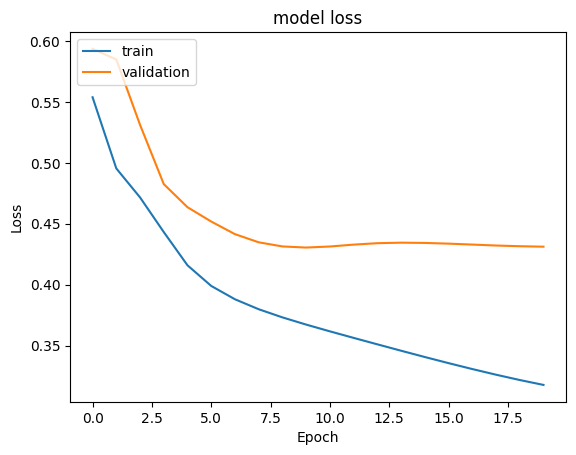

**Recall**

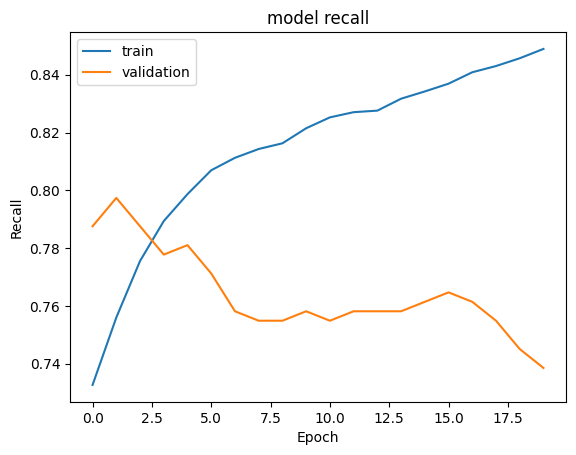

Predicting the results using best as a threshold - Train
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predicting the results using best as a threshold - Val
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


**Classification report**

classification report on training set
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.86      5574
         1.0       0.86      0.87      0.86      5574

    accuracy                           0.86     11148
   macro avg       0.86      0.86      0.86     11148
weighted avg       0.86      0.86      0.86     11148

classification report on val set
              precision    recall  f1-score   support

         0.0       0.92      0.82      0.87      1194
         1.0       0.51      0.74      0.61       306

    accuracy                           0.80      1500
   macro avg       0.72      0.78      0.74      1500
weighted avg       0.84      0.80      0.82      1500



**Confusion matrix**

Confusion matrix: training


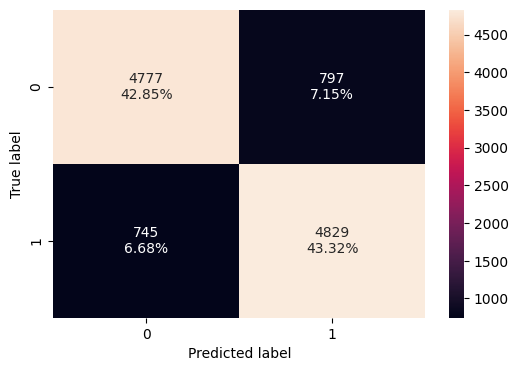

Confusion matrix: val


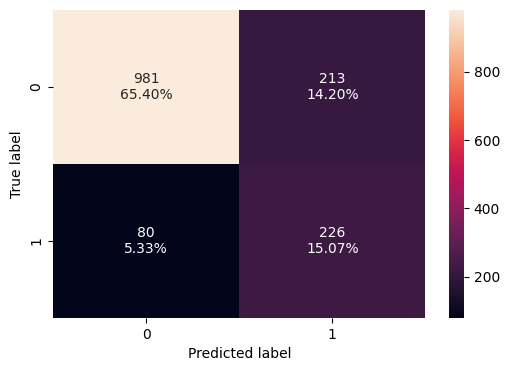

In [ ]:
ann_reports("NN with SMOTE,Adam & dropout", model_5, history_5, X_train_smote, y_train_smote)

### 6.6. >>**Extra credit**: using Keras tuner (model_6 & model_7)

#### 6.6.1. functions

In [ ]:
!pip install keras-tuner -q
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.8 MB/s eta 0:00:00


In [ ]:
def del_keras_tuner_dir(dir_to_remove):

    import shutil
    import os

    backend.clear_session()

    # Check if the directory exists
    if os.path.exists(dir_to_remove):
        try:
            shutil.rmtree(dir_to_remove)  # Use shutil.rmtree to remove the directory and its contents
            print(f"Directory '{dir_to_remove}' and its contents have been successfully deleted.")
        except OSError as e:
            print(f"Error deleting directory '{dir_to_remove}': {e}")
    else:
        print(f"Directory '{dir_to_remove}' does not exist.")


In [ ]:
def ann_tuning(hp):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
                                 activation=hp.Choice('activation_1', ['relu', 'tanh', 'sigmoid']),
                                 input_dim=X_train.shape[1]))

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(keras.layers.Dense(units=hp.Int(f'units_{i+2}', min_value=32, max_value=512, step=32),
                                     activation=hp.Choice(f'activation_{i+2}', ['relu', 'tanh', 'sigmoid'])))
        if hp.Boolean(f'dropout_{i+1}'):
            model.add(keras.layers.Dropout(rate=hp.Float(f'dropout_rate_{i+1}', 0.1, 0.5, step=0.1)))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')

    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        opt = keras.optimizers.SGD(learning_rate=learning_rate)

    # Define batch size as a hyperparameter
    batch_size = hp.Choice('batch_size', values=[32, 64, 128])

    # Store the batch size as an attribute on the model
    model.batch_size = batch_size

    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['recall'])
    return model

In [ ]:
def ann_best_params(best_hps):
  print(f"""The hyperparameter search is complete. The optimal number of layers is {best_hps.get('num_layers')}. The optimal number of units in the first densely-connected layer is {best_hps.get('units_1')}, in the second layer is {best_hps.get('units_2')}. The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}. The optimal activation function is {best_hps.get('activation_1')}. The optimal optimizer is {best_hps.get('optimizer')}. The optimal dropout rate is {best_hps.get('dropout_rate_1')} and {best_hps.get('dropout_rate_2')}. the optimal batch size is {best_hps.get('batch_size')}.""")

#### 6.6.2. (model_6) hyper-parameters search for  Training data

In [ ]:
del_keras_tuner_dir('keras_tuner_dir')

tuner = kt.Hyperband(ann_tuning,
                     objective='val_recall',
                     max_epochs=gbl_epochs,
                     directory='keras_tuner_dir',
                     project_name='churn_prediction')

tuner.search(X_train, y_train, epochs=gbl_epochs, validation_data=(X_val, y_val), class_weight = gbl_class_weight)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print("From Training data")
print(ann_best_params(best_hps))

Trial 30 Complete [00h 00m 24s]
val_recall: 0.6960784196853638

Best val_recall So Far: 1.0
Total elapsed time: 00h 07m 16s
From Training data
The hyperparameter search is complete. The optimal number of layers is 3. The optimal number of units in the first densely-connected layer is 416, in the second layer is 416. The optimal learning rate for the optimizer is 0.006620685362077487. The optimal activation function is sigmoid. The optimal optimizer is adam. The optimal dropout rate is 0.2 and 0.2. the optimal batch size is 128.
None


building a model with the best parameters found in previous step

**Loss function**

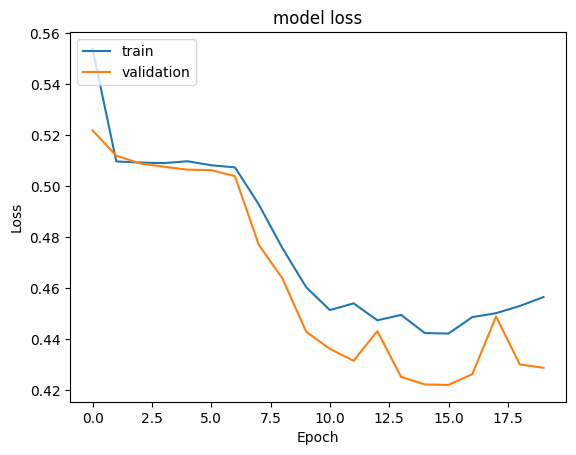

**Recall**

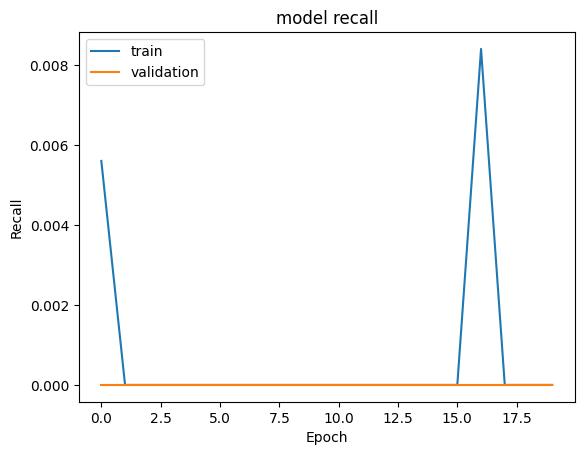

Predicting the results using best as a threshold - Train
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predicting the results using best as a threshold - Val
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


**Classification report**

classification report on training set
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89      5574
         1.0       0.00      0.00      0.00      1426

    accuracy                           0.80      7000
   macro avg       0.40      0.50      0.44      7000
weighted avg       0.63      0.80      0.71      7000

classification report on val set
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89      1194
         1.0       0.00      0.00      0.00       306

    accuracy                           0.80      1500
   macro avg       0.40      0.50      0.44      1500
weighted avg       0.63      0.80      0.71      1500



**Confusion matrix**

Confusion matrix: training


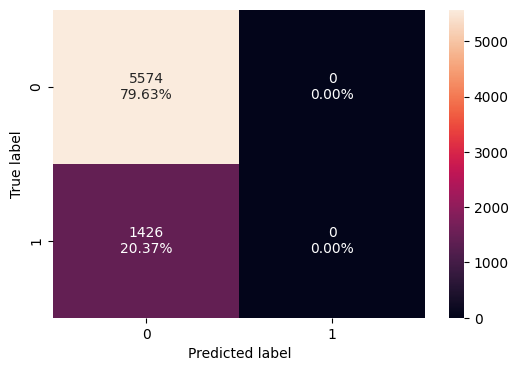

Confusion matrix: val


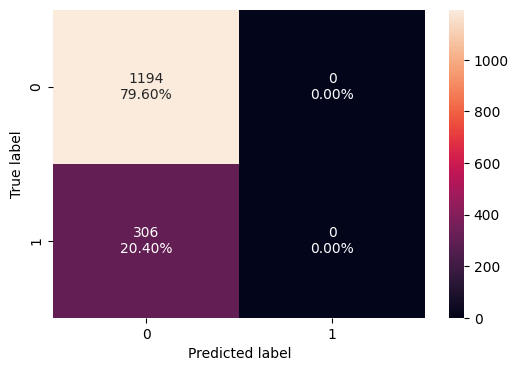

In [ ]:
# Build the model with the optimal hyperparameters and train it
model_6 = tuner.hypermodel.build(best_hps)

history_6 = model_6.fit(X_train, y_train, epochs=gbl_epochs, validation_data=(X_val, y_val), verbose=gbl_verbose)

ann_reports("NN by Keras Tuner", model_6, history_6, X_train, y_train)

#### 6.6.3. (model_7) hyper-parameters search for upsampled Training data (SMOTE)

In [ ]:
del_keras_tuner_dir('keras_tuner_dir_smote')

tuner_smote = kt.Hyperband(ann_tuning,
                     objective='val_recall',
                     max_epochs=gbl_epochs,
                     directory='keras_tuner_dir_smote',
                     project_name='churn_prediction')

tuner_smote.search(X_train_smote, y_train_smote, epochs=gbl_epochs, validation_data=(X_val, y_val), class_weight = None) # sending smote training dataset

# Get the optimal hyperparameters
best_hps_smote = tuner_smote.get_best_hyperparameters(num_trials=1)[0]

print("From training (SMOTE) data")
print(ann_best_params(best_hps_smote))

Trial 30 Complete [00h 00m 34s]
val_recall: 0.7777777910232544

Best val_recall So Far: 1.0
Total elapsed time: 00h 07m 26s
From training (SMOTE) data
The hyperparameter search is complete. The optimal number of layers is 3. The optimal number of units in the first densely-connected layer is 64, in the second layer is 96. The optimal learning rate for the optimizer is 0.0032697515090292996. The optimal activation function is tanh. The optimal optimizer is sgd. The optimal dropout rate is 0.5 and 0.30000000000000004. the optimal batch size is 32.
None


building a model with the best parameters found in previous step

**Loss function**

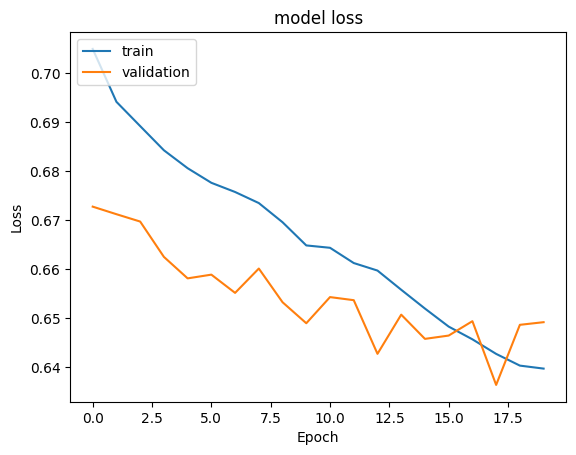

**Recall**

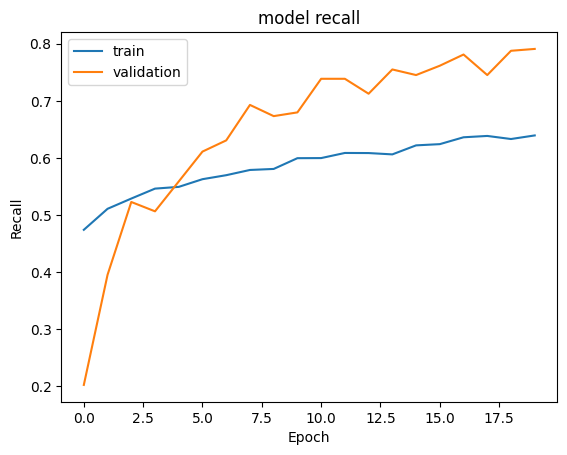

Predicting the results using best as a threshold - Train
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Predicting the results using best as a threshold - Val
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


**Classification report**

classification report on training set
              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71      5574
         1.0       0.71      0.71      0.71      5574

    accuracy                           0.71     11148
   macro avg       0.71      0.71      0.71     11148
weighted avg       0.71      0.71      0.71     11148

classification report on val set
              precision    recall  f1-score   support

         0.0       0.92      0.62      0.74      1194
         1.0       0.35      0.79      0.48       306

    accuracy                           0.65      1500
   macro avg       0.63      0.70      0.61      1500
weighted avg       0.80      0.65      0.69      1500



**Confusion matrix**

Confusion matrix: training


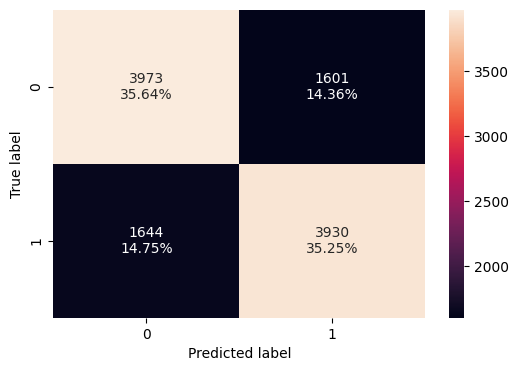

Confusion matrix: val


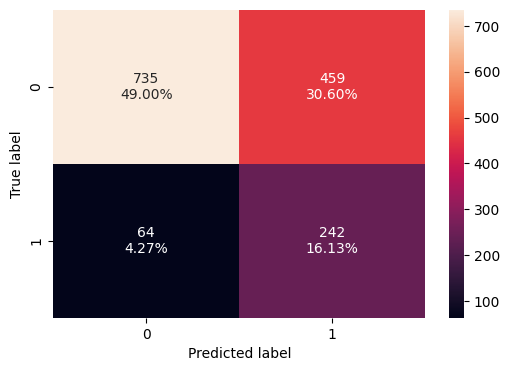

In [ ]:
# Build the model with the optimal hyperparameters and train it
model_7 = tuner_smote.hypermodel.build(best_hps_smote)

history_7 = model_7.fit(X_train_smote, y_train_smote, epochs=gbl_epochs, validation_data=(X_val, y_val), verbose=gbl_verbose)

ann_reports("NN by Keras Tuner & SMOTE", model_7, history_7, X_train_smote, y_train_smote)

## 7. MODEL COMPARISON AND FINAL MODEL SELECTION

In [ ]:
print("Training performance comparison")
train_metric_df

Training performance comparison


,recall,precision,accuracy,f1score
NN with SGD,0.713184,0.412911,0.735000,0.523014
NN with Adam,0.780505,0.515278,0.805714,0.620747
NN with Adam & Dropout,0.780505,0.515278,0.805714,0.620747
NN with SMOTE & SGD,0.772336,0.725480,0.740043,0.748175
NN with SMOTE & Adam,0.866344,0.858336,0.861679,0.862321
"NN with SMOTE,Adam & dropout",0.866344,0.858336,0.861679,0.862321
NN by Keras Tuner,0.000000,0.000000,0.796286,0.000000
NN by Keras Tuner & SMOTE,0.705059,0.710541,0.708916,0.707789


In [ ]:
print("Validation set performance comparison")
val_metric_df

Validation set performance comparison


,recall,precision,accuracy,f1score
NN with SGD,0.751634,0.442308,0.756000,0.556901
NN with Adam,0.767974,0.509761,0.802000,0.612777
NN with Adam & Dropout,0.767974,0.509761,0.802000,0.612777
NN with SMOTE & SGD,0.830065,0.356742,0.660000,0.499018
NN with SMOTE & Adam,0.738562,0.514806,0.804667,0.606711
"NN with SMOTE,Adam & dropout",0.738562,0.514806,0.804667,0.606711
NN by Keras Tuner,0.000000,0.000000,0.796000,0.000000
NN by Keras Tuner & SMOTE,0.790850,0.345221,0.651333,0.480636


In [ ]:
print("Comparison between training and validation")
train_metric_df - val_metric_df

Comparison between training and validation


,recall,precision,accuracy,f1score
NN with SGD,-0.038450,-0.029397,-0.021000,-0.033887
NN with Adam,0.012531,0.005516,0.003714,0.007970
NN with Adam & Dropout,0.012531,0.005516,0.003714,0.007970
NN with SMOTE & SGD,-0.057730,0.368739,0.080043,0.249158
NN with SMOTE & Adam,0.127782,0.343530,0.057013,0.255610
"NN with SMOTE,Adam & dropout",0.127782,0.343530,0.057013,0.255610
NN by Keras Tuner,0.000000,0.000000,0.000286,0.000000
NN by Keras Tuner & SMOTE,-0.085790,0.365319,0.057583,0.227154


selecting the best model (eg model_0 thru model_7)

In [ ]:
selected_model = model_3
selected_model_name = "NN with SMOTE & SGD"

In [ ]:
y_test_pred = selected_model.predict(X_test) ## predict using the best model
y_test_pred = (y_test_pred > 0.5)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
#lets print classification report
cr=classification_report(y_test,y_test_pred)
print(cr)

              precision    recall  f1-score   support

         0.0       0.94      0.64      0.76      1195
         1.0       0.37      0.83      0.51       305

    accuracy                           0.68      1500
   macro avg       0.65      0.73      0.64      1500
weighted avg       0.82      0.68      0.71      1500



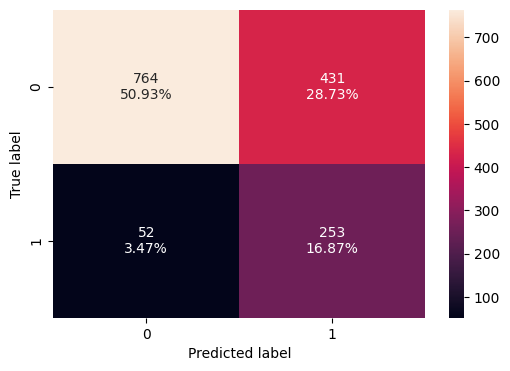

In [ ]:
#Calculating the confusion matrix
make_confusion_matrix(y_test,y_test_pred)

In [ ]:
# calculating the metrics from the test set
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# saving the metrics in the dataframe that will be used to compare
test_metric_df.loc[selected_model_name] = [test_recall, test_precision, test_accuracy, test_f1]

print("Test set performance")
display(test_metric_df)

Test set performance


,recall,precision,accuracy,f1score
NN with SMOTE & SGD,0.829508,0.369883,0.678,0.511628


In [ ]:
# Concatenate the DataFrames
all_metrics_df = pd.concat([train_metric_df, val_metric_df, test_metric_df], axis=1, keys=['Train', 'Validation', 'Test'])

all_metrics_df.loc[selected_model_name]

Train       recall       0.772336
            precision    0.725480
            accuracy     0.740043
            f1score      0.748175
Validation  recall       0.830065
            precision    0.356742
            accuracy     0.660000
            f1score      0.499018
Test        recall       0.829508
            precision    0.369883
            accuracy     0.678000
            f1score      0.511628
Name: NN with SMOTE & SGD, dtype: float64

## 8. ACTIONABLE INSIGHTS AND BUSINESS RECOMMENDATIONS

### 8.1. Key Findings from EDA

Exploratory data analysis (EDA) revealed critical insights into customer churn:

- **Age:** Customers aged 40-60 exhibit a higher churn rate, likely due to life stage and financial planning needs.
- **Product Usage:** Customers with 3-4 products are more likely to churn, suggesting a potential mismatch between product offerings and customer needs.
- **Activity:** Inactive customers are significantly more likely to churn, highlighting issues with customer engagement.
- **Imbalanced Data:** The target variable (`Exited`) was imbalanced, necessitating techniques like SMOTE and a focus on recall for model evaluation.
- **Outliers:** Features such as `Age` and `NumOfProducts` contained outliers, which may represent unique customer segments requiring further analysis.

---

### 8.2. Model Performance

For this business problem, **recall** is the primary evaluation metric, as it prioritizes minimizing false negatives (i.e., predicting that a customer will not churn when they actually do).

The best-performing model is **Model 3 (NN with SMOTE & SGD)**, selected for its high recall and consistent performance across training and validation sets. This indicates that the model effectively handles class imbalance and generalizes well. Key specifications of the model include:

- **Optimizer:** SGD
- **Dataset:** SMOTE-balanced training data
- **Training:** 20 epochs, batch size of 16, learning rate of 0.003
- **Activation Functions:** `tanh` for hidden layers, `sigmoid` for the output layer
- **Architecture:** 32 neurons in the first layer, 16 neurons in the second layer
- **Recall Performance:**
  - training: 77.23%
  - validation: 83%
  - test: 82.95%

Several artificial neural network models were developed, with experimentation on hyperparameters, class weights, and upsampling techniques. Care was taken to avoid data leakage throughout the process.

Despite extensive experimentation, no model achieved a recall higher than 90%. This suggests that alternative models, such as tree-based approaches (e.g., Random Forest, Gradient Boosting), may be better suited to the problem and could yield improved classification results.

---

### 8.3. Actionable Recommendations

1. **Targeted Engagement for 40-60 Age Group:**
   - **Action:** Launch personalized programs (e.g., retirement planning, exclusive offers) tailored to this demographic.
   - **Rationale:** Addressing their specific needs can help reduce churn in this high-risk group.

2. **Improve Product Engagement:**
   - **Action:** Analyze and enhance the usability and relevance of products for customers with 3-4 products.
   - **Rationale:** Better alignment between products and customer needs can reduce churn.

3. **Engage Inactive Customers:**
   - **Action:** Develop targeted outreach programs, such as personalized communications, rewards, or special offers, to incentivize activity.
   - **Rationale:** Reactivating inactive customers can significantly lower churn risk.

4. **Leverage the Model for Retention:**
   - **Action:** Use the selected model to identify high-risk customers and prioritize retention efforts.
   - **Rationale:** Focusing resources on customers most likely to churn maximizes the impact of retention strategies.

---

### 8.4. Business Impact

Implementing these recommendations is expected to:
- **Reduce churn** by addressing the needs of high-risk customer segments.
- **Improve customer engagement** through targeted programs and personalized outreach.
- **Strengthen the bank's financial position** by retaining valuable customers and optimizing resource allocation.

By leveraging the model's predictions, the bank can focus its efforts on the most impactful retention strategies, ultimately enhancing profitability and customer satisfaction.